# Imports:

In [23]:
import tensorflow as tf

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [10]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from mne.decoding import CSP
from sklearn.metrics import classification_report, confusion_matrix
import copy
import sys, os
import pandas as pd
import time
from scipy import signal
import scipy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#import torch
#from torch import nn
from sklearn.metrics import classification_report
from contextlib import redirect_stdout, redirect_stderr
import io
import pickle
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from torchsummary import summary
#import torchinfo
#import moabb

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [11]:
# projects/def-b09sdp/bijan/Phase2/P16.fdt
path = !pwd
path

['/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI']

# Functions:

In [12]:
def data_wrapper(data_epochs, data_labels, mode='binary'):
    
    if mode == 'binary':
        epochs = []
        labels = []

        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            binary_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2)]
            #class2_epochs = participant_epochs[participant_labels==2]
            #bi_epochs = np.concatenate((class1_epochs, class2_epochs), axis=0)
            epochs.append(binary_epochs)
    
            binary_labels = participant_labels[(participant_labels==1) | (participant_labels==2)]
            #bi_labels = np.concatenate((class1_labels, class2_labels), axis=0)
            labels.append(binary_labels)
            
    elif mode == '3_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            labels.append(multiclass_labels)
            
            
    elif mode == '4_class_RS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
        
    elif mode == '4_class_LS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
    elif mode == '6_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            labels.append(multiclass_labels)
    
    return epochs, labels

In [13]:
def epoch_label_extractor(data, events, epoch_length, num_channels, sampling_freq):
    
    data = data.to_data_frame()
    events = events[0]
    third_column = events[:, 2]
    mask = np.isin(third_column, [7, 8, 9, 10])
    MI_events = events[mask]
    
    number_of_epochs = MI_events.shape[0]
    labels = np.zeros((number_of_epochs,1)).astype(int)
    epochs = np.zeros((number_of_epochs, num_channels, epoch_length * sampling_freq))
    index = 0
    for index in range(number_of_epochs):
        start = int(MI_events[index, 0])
        end = int(MI_events[index, 0]) + epoch_length * sampling_freq
        all_channels = data.iloc[start:end]
        epochs[index,:,:] = all_channels[all_channels.columns[1: num_channels+1]].T
        
        # Because it is numbered form 7 to 10 !!!
        labels[index] = MI_events[index, 2] - 7

            
    return epochs, labels

In [14]:
def encoder(y_data, method=OneHotEncoder):
    
    encoder = OneHotEncoder()
    encoder.fit(y_data[0].reshape(-1, 1))
    
    for i in range(len(y_data)):
        
        a = encoder.transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [15]:
def calc_csp(x_train, y_train, x_test, n_components=16):
    
        csp = CSP(n_components)
        csp_fit = csp.fit(x_train, y_train)
        train_feat = csp_fit.transform(x_train)
        test_feat = csp_fit.transform(x_test)
        return train_feat, test_feat

In [16]:
def feature_extraction_4(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, filter_length=50)
        filtered_data_test = mne.filter.filter_data(data_test, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [17]:
def feature_extraction_cheby2(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(15, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [18]:
def Preprocess_validator(train_data, train_labels, test_data, sampling_freq, n_components=2):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(40, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features, filtered_data.reshape((n_epochs_train, n_split, n_channels, n_samples))

# Device (GPU\CPU\MPS)

In [19]:

if tf.config.list_physical_devices('GPU'):
    device = "cuda"
else:
    # Check if TensorFlow Multi-Process Service (MPS) is available
    if tf.config.experimental.list_physical_devices('MPS'):
        device = "mps"
    else:
        device = "cpu"

print(f"Using {device} device")


Using cuda device


# EEGNet Model:

In [20]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)


In [27]:
from tensorflow.keras.optimizers import Adam

# Create the EEGNet model
model = EEGNet(nb_classes=4, Chans=22, Samples=1000, dropoutRate=0.5, kernLength=22, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout')

# Compile the model
optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22, 1000, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 22, 1000, 8)       176       
                                                                 
 batch_normalization (BatchN  (None, 22, 1000, 8)      32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 1000, 16)      352       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 1000, 16)      64        
 hNormalization)                                                 
                                                             

2024-01-14 08:38:11.030565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13625 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-01-14 08:38:11.033432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13625 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:5f:00.0, compute capability: 7.5
2024-01-14 08:38:11.035526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13625 MB memory:  -> device: 2, name: Tesla T4, pci bus id: 0000:87:00.0, compute capability: 7.5
2024-01-14 08:38:11.037520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13625 MB memory:  -> device: 3, name: Tesla T4, pci bus id: 0000:d8:00.0, compute capability: 7.5


# Data reading:

In [29]:
raw_data_path = "D:/Research Dr. Power/BCI_IV_2a/BCICIV_2a_gdf"

try: 
    if path[0] == '/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI':
        print("Running on cloud ...")
        print("Please make sure to modify how you read the data according to your need!\n\n")
        raw_data_path = "/home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf"
            

except NameError:
    print("Running local ...")
    print("Please make sure to change the data path!\n\n")
    raw_data_path = "D:/Research Dr. Power/BCI_IV_2a/BCICIV_2a_gdf"
    
    

data_epochs = []
data_labels = []


for participant_id in range(1, 10):
    participant_E = f"A0{participant_id}E"
    participant_T = f"A0{participant_id}T"

    file_path_E = f"{raw_data_path}/{participant_E}.gdf"
    file_path_T = f"{raw_data_path}/{participant_T}.gdf"

    raw_train = mne.io.read_raw_gdf(file_path_T, preload=True)
    raw_test = mne.io.read_raw_gdf(file_path_E, preload=True)


    train_events = mne.events_from_annotations(raw_train)
    test_events = mne.events_from_annotations(raw_test)

    train_epochs, train_labels = epoch_label_extractor(raw_train, train_events, epoch_length = 4, num_channels = 22, sampling_freq = 250)

    
    data_epochs.append(train_epochs)
    data_labels.append(train_labels)


Running on cloud ...
Please make sure to modify how you read the data according to your need!


Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 677168  =      0.000 ...  2708.672 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A02E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 662665  =      0.000 ...  2650.660 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A03E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 648774  =      0.000 ...  2595.096 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A04E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660046  =      0.000 ...  2640.184 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A05E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 679862  =      0.000 ...  2719.448 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 678979  =      0.000 ...  2715.916 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A06E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 666372  =      0.000 ...  2665.488 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A07E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673134  =      0.000 ...  2692.536 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 675269  =      0.000 ...  2701.076 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A08E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 687791  =      0.000 ...  2751.164 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from /home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf/A09E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 675097  =      0.000 ...  2700.388 secs...


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.10.2/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']


In [30]:
for i in range(9):
    print("Subject {} train epochs:    ".format(i+1), data_epochs[i].shape, "    Subject {} train labels:    ".format(i+1), data_labels[i].shape)


Subject 1 train epochs:     (288, 22, 1000)     Subject 1 train labels:     (288, 1)
Subject 2 train epochs:     (288, 22, 1000)     Subject 2 train labels:     (288, 1)
Subject 3 train epochs:     (288, 22, 1000)     Subject 3 train labels:     (288, 1)
Subject 4 train epochs:     (144, 22, 1000)     Subject 4 train labels:     (144, 1)
Subject 5 train epochs:     (288, 22, 1000)     Subject 5 train labels:     (288, 1)
Subject 6 train epochs:     (288, 22, 1000)     Subject 6 train labels:     (288, 1)
Subject 7 train epochs:     (288, 22, 1000)     Subject 7 train labels:     (288, 1)
Subject 8 train epochs:     (288, 22, 1000)     Subject 8 train labels:     (288, 1)
Subject 9 train epochs:     (288, 22, 1000)     Subject 9 train labels:     (288, 1)


In [33]:
# all_data_epochs = np.zeros(len(train_data_epochs)).tolist()
# all_data_labels = np.zeros(len(train_data_epochs)).tolist()

# for i in range(len(train_data_epochs)):
#     all_data_epochs[i] = np.concatenate((train_data_epochs[i], test_data_epochs[i]), axis=0)
#     all_data_labels[i] = np.concatenate((train_data_labels[i], test_data_labels[i]), axis=0)


all_data_epochs = data_epochs
all_data_labels = data_labels

In [34]:
# # Checking if the concatenation does not have a problem!

# print("Specific element in train and test sets:      ", train_data_epochs[i][10, 10, 10], test_data_epochs[i][100, 13, 14])
# print("The same element in all data set combined:    ", all_data_epochs[i][10, 10, 10], all_data_epochs[i][388, 13, 14])
# print("\n\n")
# print("Checking the labels in train and test:        ", train_data_labels[i][10], test_data_labels[i][100])
# print("The same element in all data set combined:    ", all_data_labels[i][10], all_data_labels[i][388])

In [35]:
all_data_labels[0][:, 0]

array([3, 2, 1, 0, 0, 1, 2, 3, 1, 2, 0, 0, 0, 3, 1, 1, 0, 0, 2, 0, 1, 3,
       3, 2, 0, 3, 3, 1, 3, 3, 1, 0, 1, 2, 2, 2, 3, 2, 0, 3, 1, 2, 1, 2,
       3, 1, 2, 0, 0, 0, 3, 1, 0, 2, 0, 2, 1, 3, 0, 2, 2, 0, 2, 1, 3, 3,
       3, 2, 0, 3, 1, 3, 1, 0, 2, 1, 0, 2, 2, 0, 2, 3, 3, 1, 0, 1, 3, 1,
       3, 2, 1, 1, 1, 2, 3, 0, 1, 3, 0, 2, 2, 3, 0, 0, 2, 1, 3, 3, 3, 1,
       0, 2, 1, 3, 0, 3, 2, 1, 3, 3, 0, 1, 1, 2, 3, 1, 0, 0, 3, 1, 0, 2,
       1, 1, 2, 0, 3, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 2, 1, 2, 3, 0, 3,
       0, 0, 1, 3, 2, 1, 3, 2, 3, 2, 3, 1, 1, 3, 0, 1, 1, 1, 2, 3, 0, 3,
       0, 2, 0, 3, 0, 2, 0, 1, 2, 2, 3, 0, 1, 3, 1, 2, 2, 0, 3, 1, 3, 0,
       0, 2, 2, 1, 3, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 2, 3, 0, 1, 2,
       1, 0, 3, 0, 3, 0, 0, 0, 0, 2, 2, 3, 1, 2, 2, 2, 3, 2, 0, 2, 0, 3,
       1, 3, 3, 2, 3, 3, 2, 1, 3, 2, 0, 1, 1, 1, 2, 1, 3, 2, 3, 1, 2, 0,
       3, 0, 2, 3, 0, 2, 0, 1, 1, 0, 3, 0, 3, 2, 2, 0, 2, 1, 1, 0, 2, 0,
       1, 0])

In [36]:
for i in range(len(all_data_epochs)):
    all_data_epochs[i] = np.expand_dims(all_data_epochs[i], 3)
    print("All data epoch shape (sub {}):    ".format(i), all_data_epochs[i].shape, "    All label shape (sub {}):     ".format(i), all_data_labels[i].shape)

All data epoch shape (sub 0):     (288, 22, 1000, 1)     All label shape (sub 0):      (288, 1)
All data epoch shape (sub 1):     (288, 22, 1000, 1)     All label shape (sub 1):      (288, 1)
All data epoch shape (sub 2):     (288, 22, 1000, 1)     All label shape (sub 2):      (288, 1)
All data epoch shape (sub 3):     (144, 22, 1000, 1)     All label shape (sub 3):      (144, 1)
All data epoch shape (sub 4):     (288, 22, 1000, 1)     All label shape (sub 4):      (288, 1)
All data epoch shape (sub 5):     (288, 22, 1000, 1)     All label shape (sub 5):      (288, 1)
All data epoch shape (sub 6):     (288, 22, 1000, 1)     All label shape (sub 6):      (288, 1)
All data epoch shape (sub 7):     (288, 22, 1000, 1)     All label shape (sub 7):      (288, 1)
All data epoch shape (sub 8):     (288, 22, 1000, 1)     All label shape (sub 8):      (288, 1)


In [37]:
all_data_labels[1][:10]

array([[0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [2],
       [1],
       [3]])

# Encoding

In [38]:
no_encode = copy.deepcopy(all_data_labels)
encoded = encoder(all_data_labels)


In [39]:
print("Epochs Length:", len(all_data_labels))
print("labels Length:", len(encoded))
print('\n\n')
print("Participant 16 - Epochs[0] shape:", no_encode[3].shape)
print("Participant 16 - labels[0] shape:", encoded[3].shape)
print('\n\n')
print("Participant 16 - labels[0]:")
print(all_data_labels[3][:5])

Epochs Length: 9
labels Length: 9



Participant 16 - Epochs[0] shape: (144, 1)
Participant 16 - labels[0] shape: (144, 4)



Participant 16 - labels[0]:
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


# Within Subject:

(288, 1)
Outer Loop 1 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 44ms/step - loss: 1.3792 - accuracy: 0.2435 - val_loss: 1.3850 - val_accuracy: 0.3103
Epoch 2/500
8/8 [==============================] - 0s 24ms/step - loss: 1.3412 - accuracy: 0.3913 - val_loss: 1.3821 - val_accuracy: 0.3103
Epoch 3/500
8/8 [==============================] - 0s 22ms/step - loss: 1.3008 - accuracy: 0.4478 - val_loss: 1.3782 - val_accuracy: 0.3103
Epoch 4/500
8/8 [==============================] - 0s 23ms/step - loss: 1.2634 - accuracy: 0.5043 - val_lo

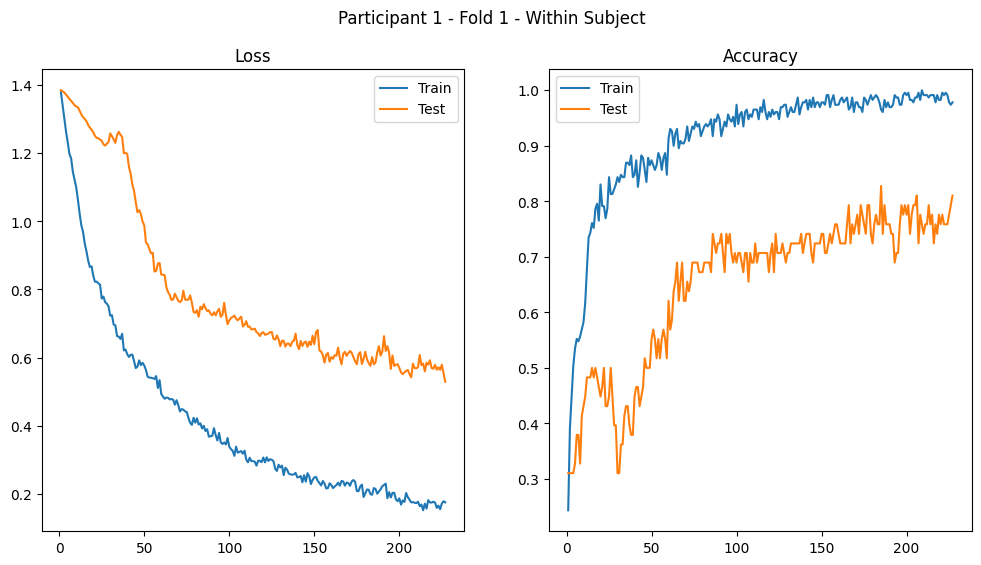

Outer Loop 2 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 43ms/step - loss: 1.4137 - accuracy: 0.2478 - val_loss: 1.3841 - val_accuracy: 0.3103
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.3361 - accuracy: 0.4348 - val_loss: 1.3812 - val_accuracy: 0.3276
Epoch 3/500
8/8 [==============================] - 0s 18ms/step - loss: 1.2894 - accuracy: 0.4826 - val_loss: 1.3780 - val_accuracy: 0.3793
Epoch 4/500
8/8 [==============================] - 0s 18ms/step - loss: 1.2417 - accuracy: 0.5435 - val_loss: 1.374

<Figure size 640x480 with 0 Axes>

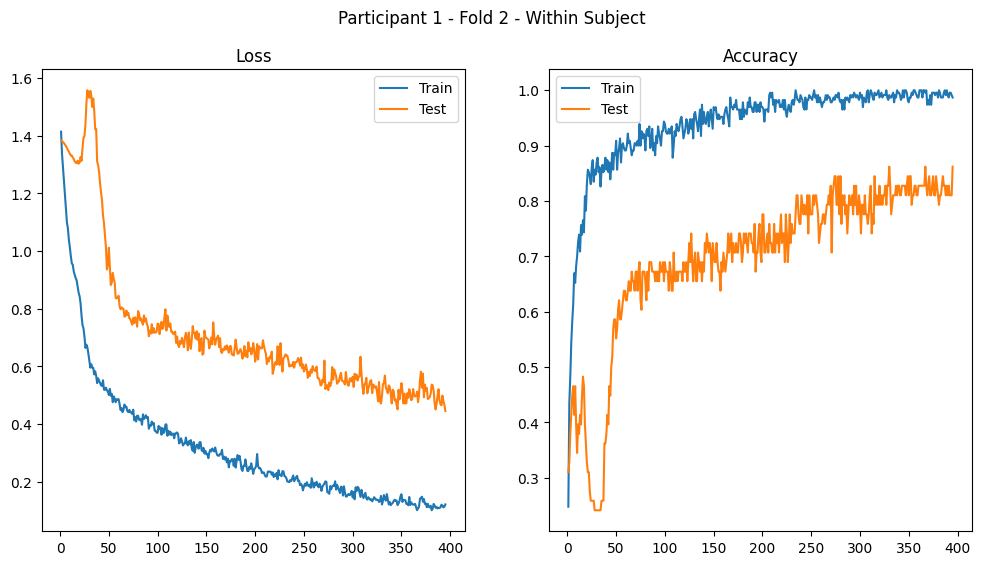

Outer Loop 3 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 44ms/step - loss: 1.4042 - accuracy: 0.2826 - val_loss: 1.3852 - val_accuracy: 0.3621
Epoch 2/500
8/8 [==============================] - 0s 21ms/step - loss: 1.2956 - accuracy: 0.4739 - val_loss: 1.3828 - val_accuracy: 0.3448
Epoch 3/500
8/8 [==============================] - 0s 22ms/step - loss: 1.2379 - accuracy: 0.5174 - val_loss: 1.3794 - val_accuracy: 0.3966
Epoch 4/500
8/8 [==============================] - 0s 20ms/step - loss: 1.1670 - accuracy: 0.6000 - val_loss: 1.377

<Figure size 640x480 with 0 Axes>

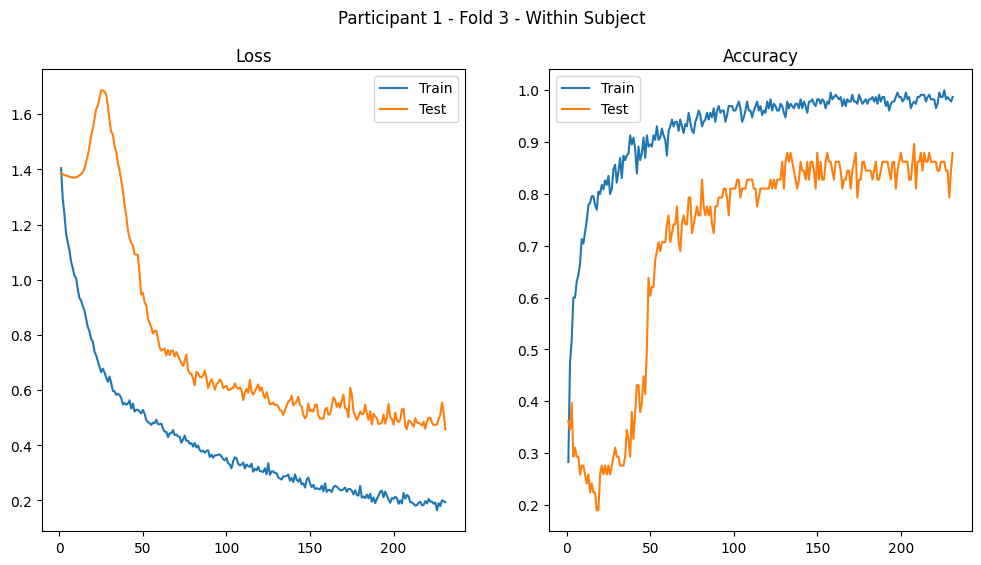

Outer Loop 4 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 62ms/step - loss: 1.4049 - accuracy: 0.2727 - val_loss: 1.3840 - val_accuracy: 0.3509
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.3171 - accuracy: 0.5108 - val_loss: 1.3822 - val_accuracy: 0.3509
Epoch 3/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2636 - accuracy: 0.5628 - val_loss: 1.3796 - val_accuracy: 0.4035
Epoch 4/500
8/8 [==============================] - 0s 18ms/step - loss: 1.2256 - accuracy: 0.5671 - val_loss: 1.376

<Figure size 640x480 with 0 Axes>

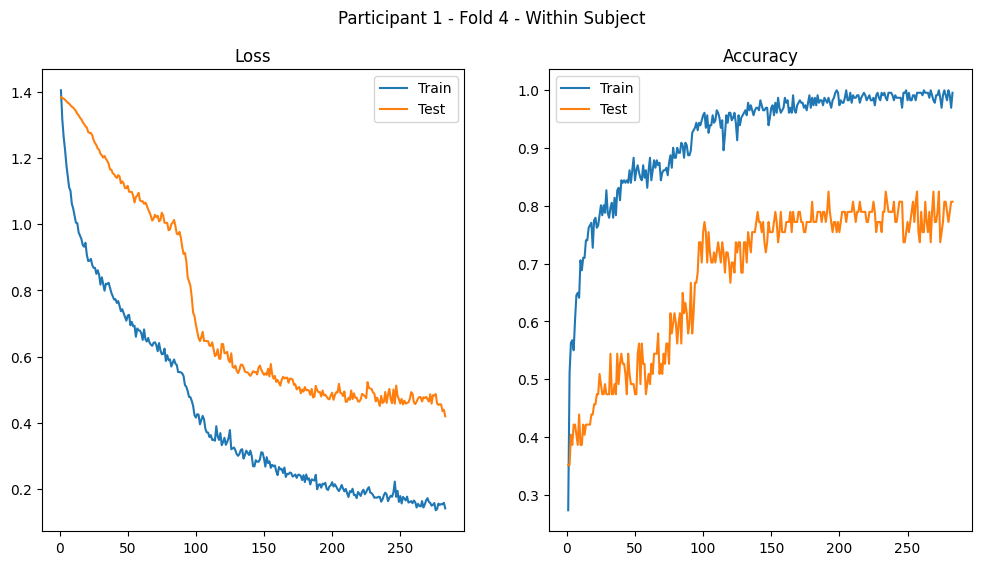

Outer Loop 5 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 50ms/step - loss: 1.3934 - accuracy: 0.2900 - val_loss: 1.3836 - val_accuracy: 0.4035
Epoch 2/500
8/8 [==============================] - 0s 26ms/step - loss: 1.3281 - accuracy: 0.4242 - val_loss: 1.3801 - val_accuracy: 0.4912
Epoch 3/500
8/8 [==============================] - 0s 26ms/step - loss: 1.2884 - accuracy: 0.5152 - val_loss: 1.3750 - val_accuracy: 0.5088
Epoch 4/500
8/8 [==============================] - 0s 23ms/step - loss: 1.2357 - accuracy: 0.5584 - val_loss: 1.368

<Figure size 640x480 with 0 Axes>

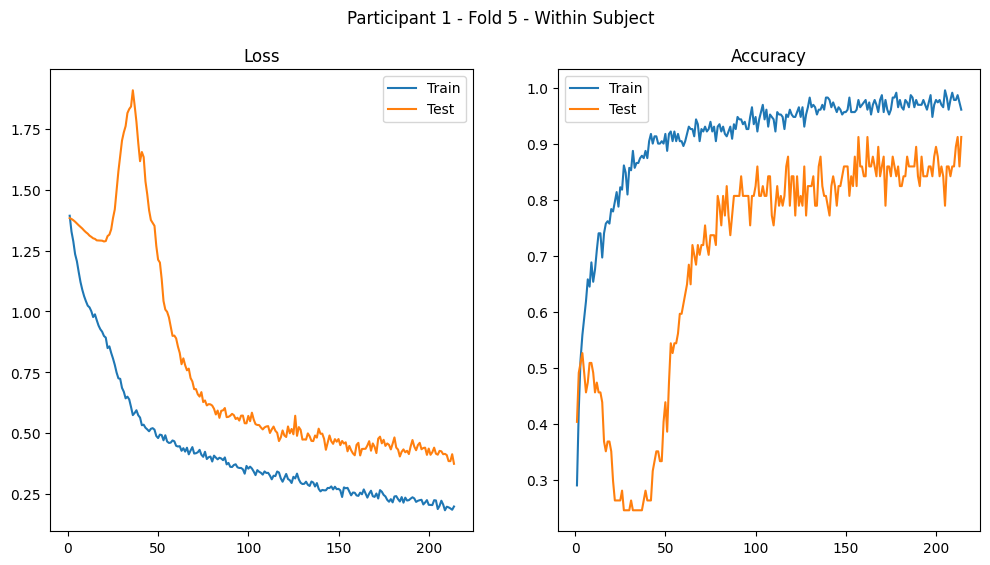

(288, 1)
Outer Loop 1 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 43ms/step - loss: 1.4487 - accuracy: 0.2348 - val_loss: 1.3847 - val_accuracy: 0.2931
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.3338 - accuracy: 0.4348 - val_loss: 1.3810 - val_accuracy: 0.4138
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2845 - accuracy: 0.5043 - val_loss: 1.3771 - val_accuracy: 0.4138
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2563 - accuracy: 0.4957 - val_lo

<Figure size 640x480 with 0 Axes>

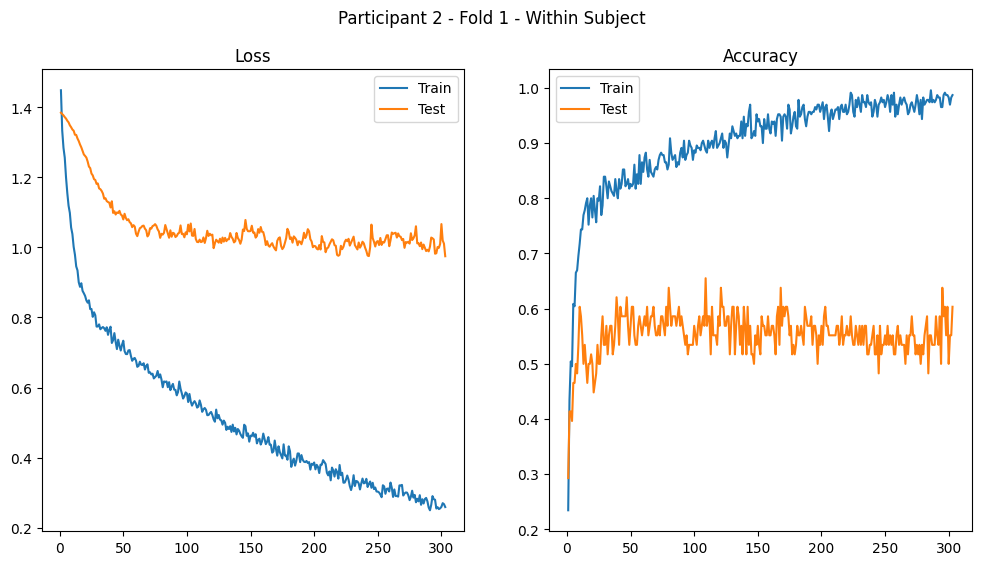

Outer Loop 2 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 38ms/step - loss: 1.4058 - accuracy: 0.2913 - val_loss: 1.3865 - val_accuracy: 0.1897
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.3192 - accuracy: 0.4652 - val_loss: 1.3851 - val_accuracy: 0.3103
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2705 - accuracy: 0.5391 - val_loss: 1.3828 - val_accuracy: 0.3276
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2302 - accuracy: 0.5043 - val_loss: 1.379

<Figure size 640x480 with 0 Axes>

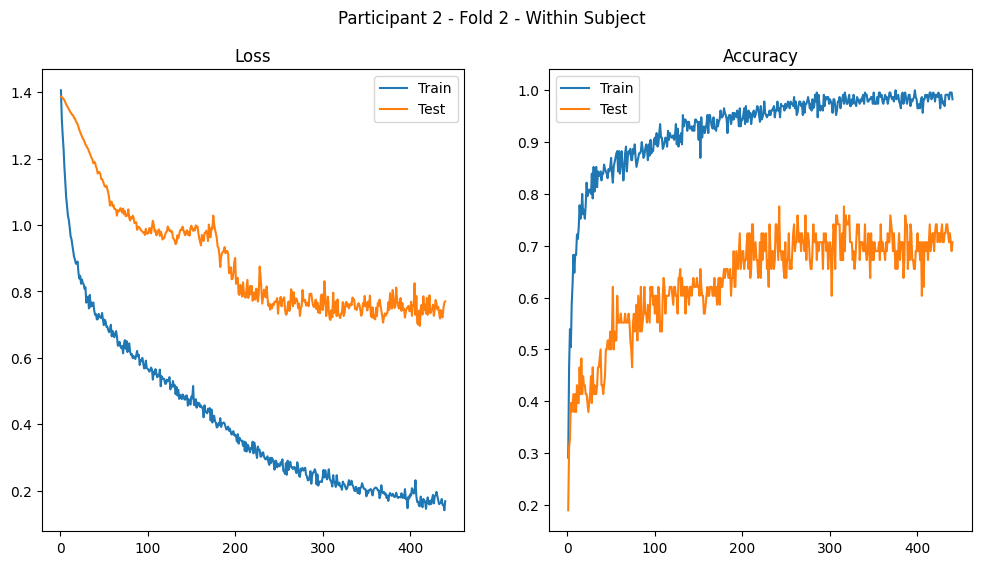

Outer Loop 3 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 48ms/step - loss: 1.4155 - accuracy: 0.2565 - val_loss: 1.3861 - val_accuracy: 0.2586
Epoch 2/500
8/8 [==============================] - 0s 24ms/step - loss: 1.3148 - accuracy: 0.4304 - val_loss: 1.3854 - val_accuracy: 0.2414
Epoch 3/500
8/8 [==============================] - 0s 23ms/step - loss: 1.2669 - accuracy: 0.5043 - val_loss: 1.3842 - val_accuracy: 0.3103
Epoch 4/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2110 - accuracy: 0.5696 - val_loss: 1.382

<Figure size 640x480 with 0 Axes>

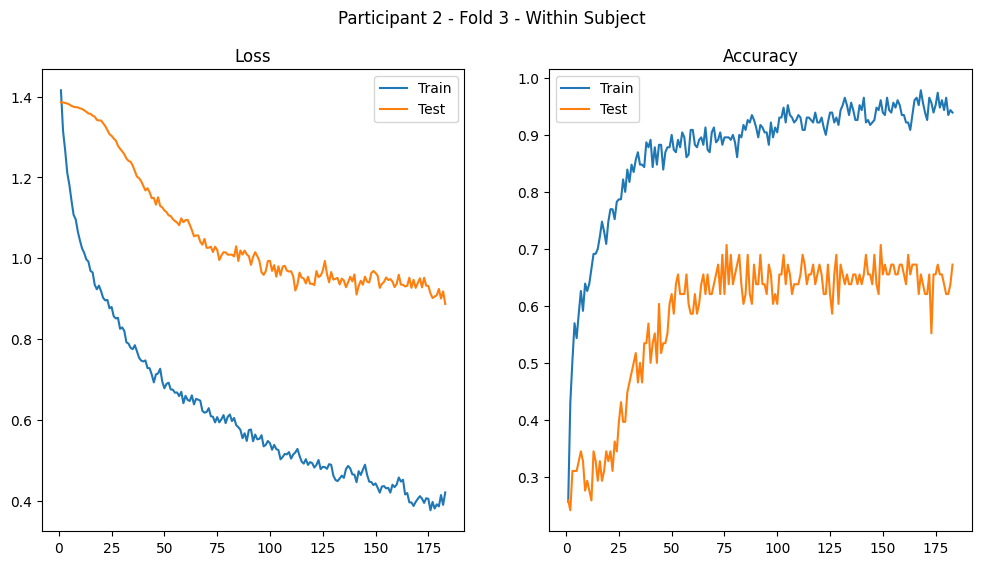

Outer Loop 4 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 46ms/step - loss: 1.3787 - accuracy: 0.2900 - val_loss: 1.3843 - val_accuracy: 0.3158
Epoch 2/500
8/8 [==============================] - 0s 21ms/step - loss: 1.3240 - accuracy: 0.4502 - val_loss: 1.3823 - val_accuracy: 0.2807
Epoch 3/500
8/8 [==============================] - 0s 18ms/step - loss: 1.2618 - accuracy: 0.6017 - val_loss: 1.3798 - val_accuracy: 0.3333
Epoch 4/500
8/8 [==============================] - 0s 17ms/step - loss: 1.1948 - accuracy: 0.6364 - val_loss: 1.376

<Figure size 640x480 with 0 Axes>

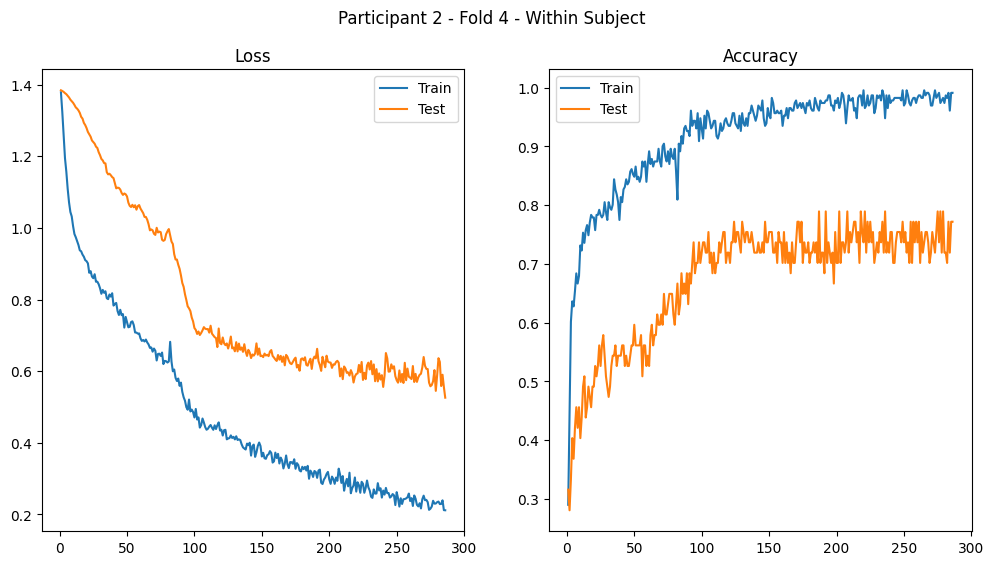

Outer Loop 5 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 43ms/step - loss: 1.3887 - accuracy: 0.2641 - val_loss: 1.3852 - val_accuracy: 0.3333
Epoch 2/500
8/8 [==============================] - 0s 21ms/step - loss: 1.3149 - accuracy: 0.4719 - val_loss: 1.3836 - val_accuracy: 0.3158
Epoch 3/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2551 - accuracy: 0.5931 - val_loss: 1.3810 - val_accuracy: 0.2982
Epoch 4/500
8/8 [==============================] - 0s 18ms/step - loss: 1.1931 - accuracy: 0.5541 - val_loss: 1.376

<Figure size 640x480 with 0 Axes>

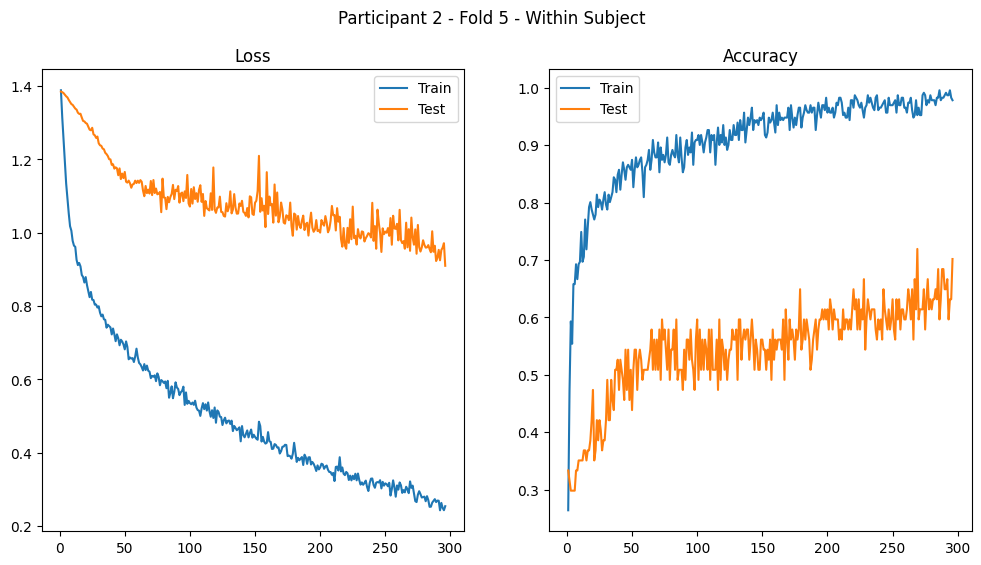

(288, 1)
Outer Loop 1 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 44ms/step - loss: 1.3919 - accuracy: 0.2826 - val_loss: 1.3847 - val_accuracy: 0.1897
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.3133 - accuracy: 0.4652 - val_loss: 1.3832 - val_accuracy: 0.2414
Epoch 3/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2645 - accuracy: 0.5783 - val_loss: 1.3812 - val_accuracy: 0.2414
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2124 - accuracy: 0.5870 - val_lo

<Figure size 640x480 with 0 Axes>

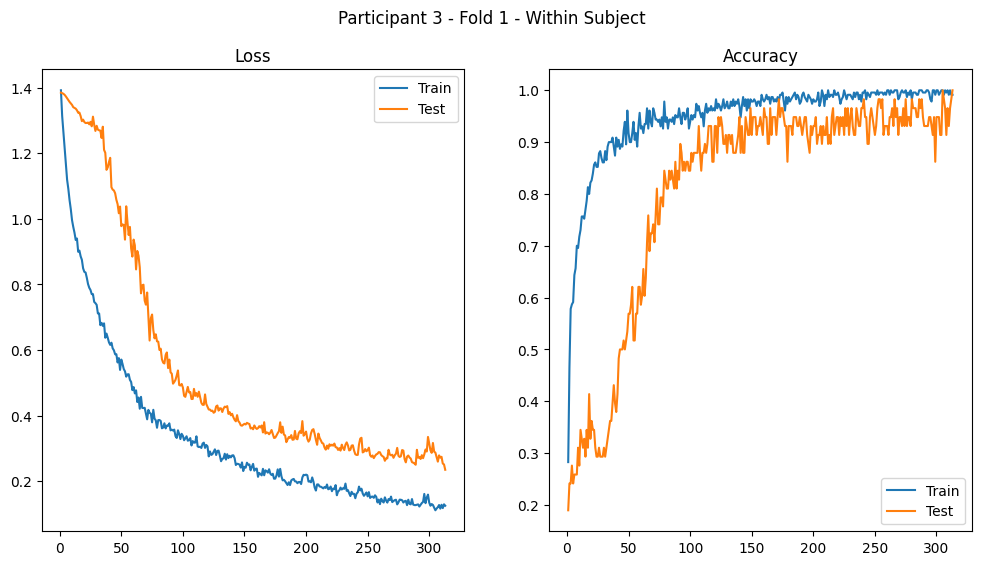

Outer Loop 2 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 45ms/step - loss: 1.3937 - accuracy: 0.2870 - val_loss: 1.3847 - val_accuracy: 0.4138
Epoch 2/500
8/8 [==============================] - 0s 20ms/step - loss: 1.3061 - accuracy: 0.5304 - val_loss: 1.3823 - val_accuracy: 0.3793
Epoch 3/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2611 - accuracy: 0.5913 - val_loss: 1.3796 - val_accuracy: 0.3276
Epoch 4/500
8/8 [==============================] - 0s 17ms/step - loss: 1.2002 - accuracy: 0.6870 - val_loss: 1.376

<Figure size 640x480 with 0 Axes>

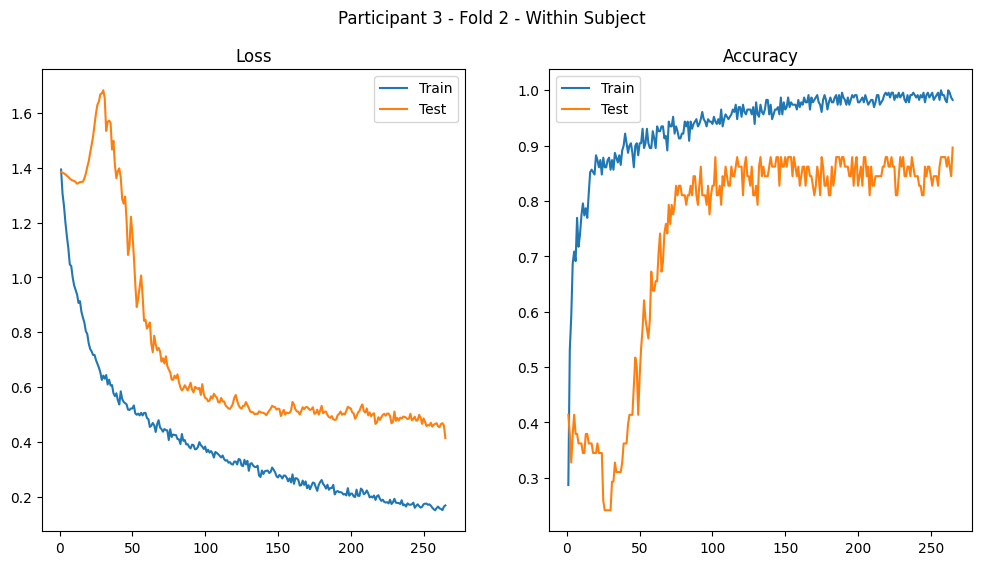

Outer Loop 3 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 50ms/step - loss: 1.3973 - accuracy: 0.2348 - val_loss: 1.3839 - val_accuracy: 0.3621
Epoch 2/500
8/8 [==============================] - 0s 24ms/step - loss: 1.3154 - accuracy: 0.4957 - val_loss: 1.3812 - val_accuracy: 0.3621
Epoch 3/500
8/8 [==============================] - 0s 24ms/step - loss: 1.2640 - accuracy: 0.6000 - val_loss: 1.3777 - val_accuracy: 0.4655
Epoch 4/500
8/8 [==============================] - 0s 22ms/step - loss: 1.2075 - accuracy: 0.6391 - val_loss: 1.372

<Figure size 640x480 with 0 Axes>

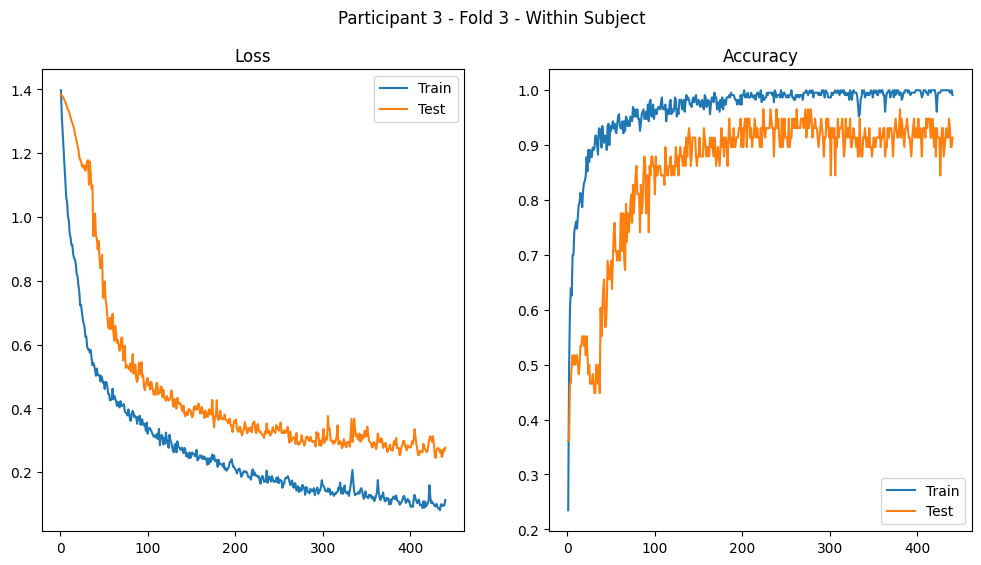

Outer Loop 4 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 45ms/step - loss: 1.4008 - accuracy: 0.3117 - val_loss: 1.3839 - val_accuracy: 0.4211
Epoch 2/500
8/8 [==============================] - 0s 21ms/step - loss: 1.3148 - accuracy: 0.5065 - val_loss: 1.3822 - val_accuracy: 0.4211
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2601 - accuracy: 0.5411 - val_loss: 1.3790 - val_accuracy: 0.3333
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.1902 - accuracy: 0.6277 - val_loss: 1.375

<Figure size 640x480 with 0 Axes>

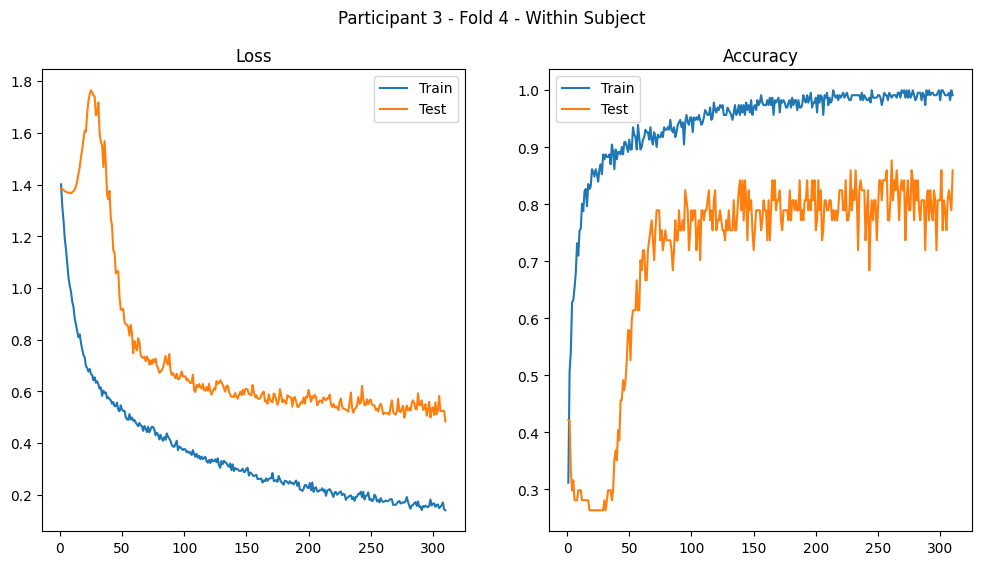

Outer Loop 5 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 47ms/step - loss: 1.3846 - accuracy: 0.2987 - val_loss: 1.3853 - val_accuracy: 0.2807
Epoch 2/500
8/8 [==============================] - 0s 22ms/step - loss: 1.3120 - accuracy: 0.4762 - val_loss: 1.3837 - val_accuracy: 0.2807
Epoch 3/500
8/8 [==============================] - 0s 21ms/step - loss: 1.2651 - accuracy: 0.5281 - val_loss: 1.3807 - val_accuracy: 0.3333
Epoch 4/500
8/8 [==============================] - 0s 21ms/step - loss: 1.2045 - accuracy: 0.6234 - val_loss: 1.376

<Figure size 640x480 with 0 Axes>

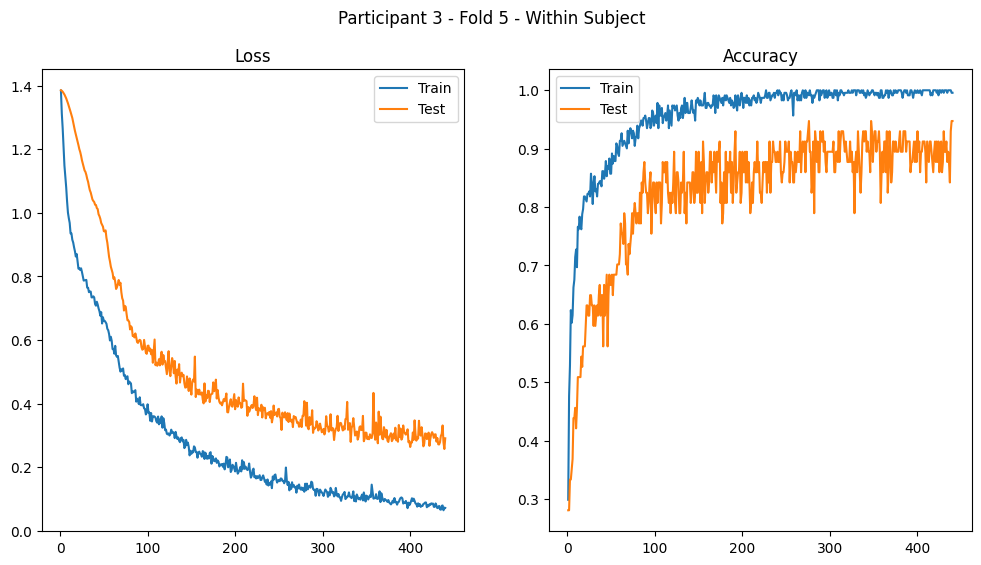

(144, 1)
Outer Loop 1 

      Train epochs' shape:                                (115, 22, 1000, 1)
      Test epochs' shape:                                 (29, 22, 1000, 1)
      Train labels' shape:                                (115, 4)
      Test labels' shape:                                 (29, 4)
      Train labels' shape (without encoding):             (115, 1)
      Test labels' shape (without encoding):              (29, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
4/4 [==============================] - 1s 138ms/step - loss: 1.3648 - accuracy: 0.4174 - val_loss: 1.3641 - val_accuracy: 0.7586
Epoch 2/500
4/4 [==============================] - 0s 31ms/step - loss: 1.0869 - accuracy: 0.6174 - val_loss: 1.3415 - val_accuracy: 0.7931
Epoch 3/500
4/4 [==============================] - 0s 29ms/step - loss: 0.9402 - accuracy: 0.6696 - val_loss: 1.3151 - val_accuracy: 0.8621
Epoch 4/500
4/4 [==============================] - 0s 29ms/step - loss: 0.8396 - accuracy: 0.7565 - val_l

<Figure size 640x480 with 0 Axes>

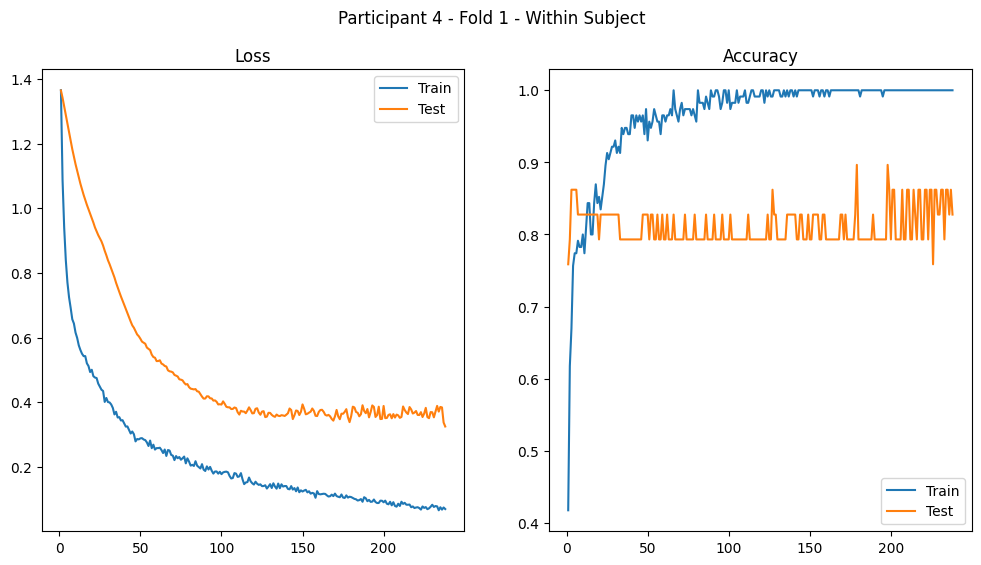

Outer Loop 2 

      Train epochs' shape:                                (115, 22, 1000, 1)
      Test epochs' shape:                                 (29, 22, 1000, 1)
      Train labels' shape:                                (115, 4)
      Test labels' shape:                                 (29, 4)
      Train labels' shape (without encoding):             (115, 1)
      Test labels' shape (without encoding):              (29, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
4/4 [==============================] - 1s 96ms/step - loss: 1.4510 - accuracy: 0.2870 - val_loss: 1.3772 - val_accuracy: 0.4828
Epoch 2/500
4/4 [==============================] - 0s 36ms/step - loss: 1.1462 - accuracy: 0.5913 - val_loss: 1.3654 - val_accuracy: 0.4138
Epoch 3/500
4/4 [==============================] - 0s 37ms/step - loss: 0.9937 - accuracy: 0.6348 - val_loss: 1.3499 - val_accuracy: 0.4828
Epoch 4/500
4/4 [==============================] - 0s 37ms/step - loss: 0.9021 - accuracy: 0.7391 - val_loss: 1.330

<Figure size 640x480 with 0 Axes>

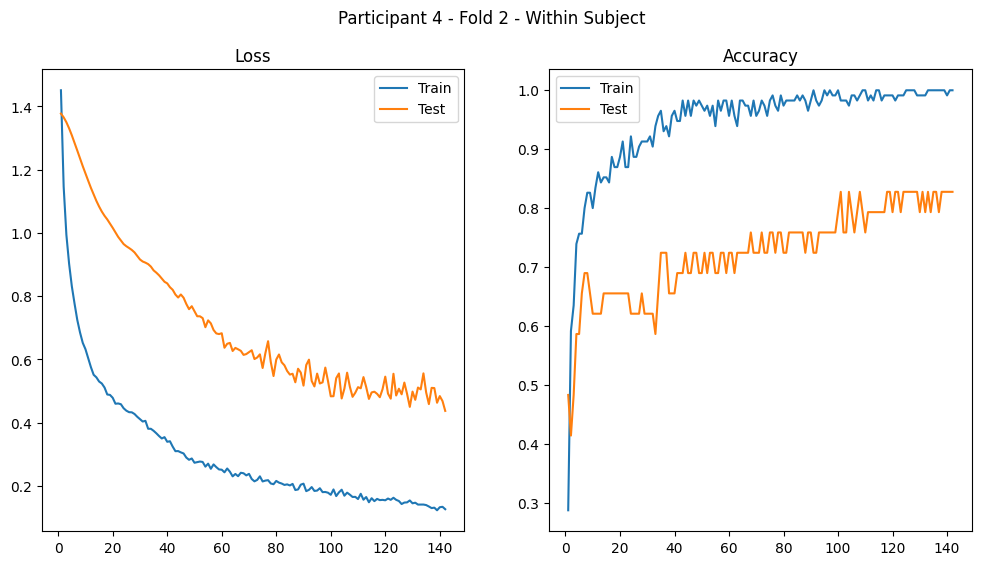

Outer Loop 3 

      Train epochs' shape:                                (115, 22, 1000, 1)
      Test epochs' shape:                                 (29, 22, 1000, 1)
      Train labels' shape:                                (115, 4)
      Test labels' shape:                                 (29, 4)
      Train labels' shape (without encoding):             (115, 1)
      Test labels' shape (without encoding):              (29, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
4/4 [==============================] - 1s 94ms/step - loss: 1.3969 - accuracy: 0.4000 - val_loss: 1.3786 - val_accuracy: 0.4483
Epoch 2/500
4/4 [==============================] - 0s 34ms/step - loss: 1.1365 - accuracy: 0.5652 - val_loss: 1.3648 - val_accuracy: 0.5172
Epoch 3/500
4/4 [==============================] - 0s 32ms/step - loss: 0.9762 - accuracy: 0.6957 - val_loss: 1.3463 - val_accuracy: 0.5517
Epoch 4/500
4/4 [==============================] - 0s 35ms/step - loss: 0.8909 - accuracy: 0.7217 - val_loss: 1.324

<Figure size 640x480 with 0 Axes>

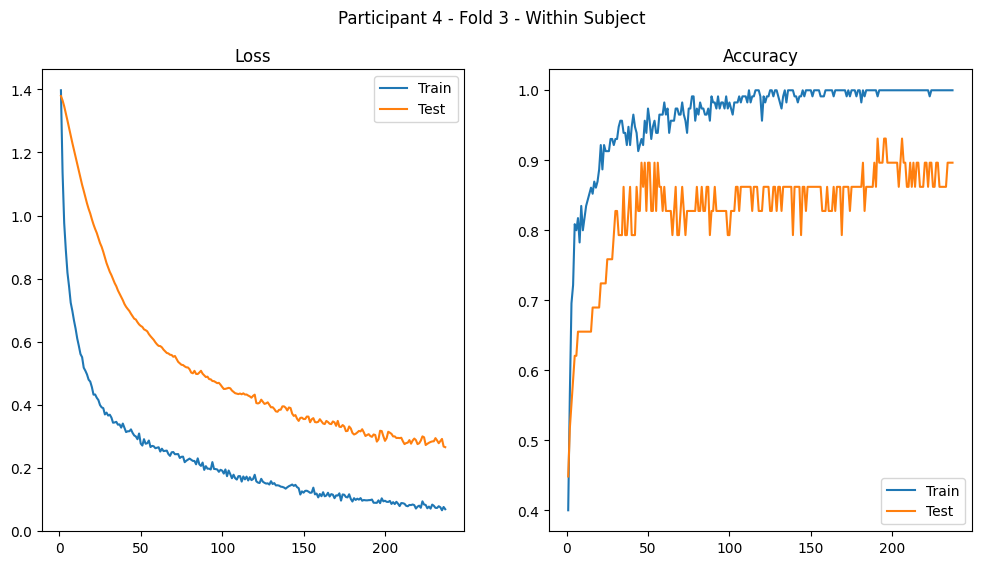

Outer Loop 4 

      Train epochs' shape:                                (115, 22, 1000, 1)
      Test epochs' shape:                                 (29, 22, 1000, 1)
      Train labels' shape:                                (115, 4)
      Test labels' shape:                                 (29, 4)
      Train labels' shape (without encoding):             (115, 1)
      Test labels' shape (without encoding):              (29, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
4/4 [==============================] - 1s 93ms/step - loss: 1.4367 - accuracy: 0.3478 - val_loss: 1.3748 - val_accuracy: 0.5862
Epoch 2/500
4/4 [==============================] - 0s 35ms/step - loss: 1.1247 - accuracy: 0.6783 - val_loss: 1.3601 - val_accuracy: 0.6552
Epoch 3/500
4/4 [==============================] - 0s 34ms/step - loss: 0.9458 - accuracy: 0.7565 - val_loss: 1.3411 - val_accuracy: 0.6897
Epoch 4/500
4/4 [==============================] - 0s 36ms/step - loss: 0.8394 - accuracy: 0.8174 - val_loss: 1.318

<Figure size 640x480 with 0 Axes>

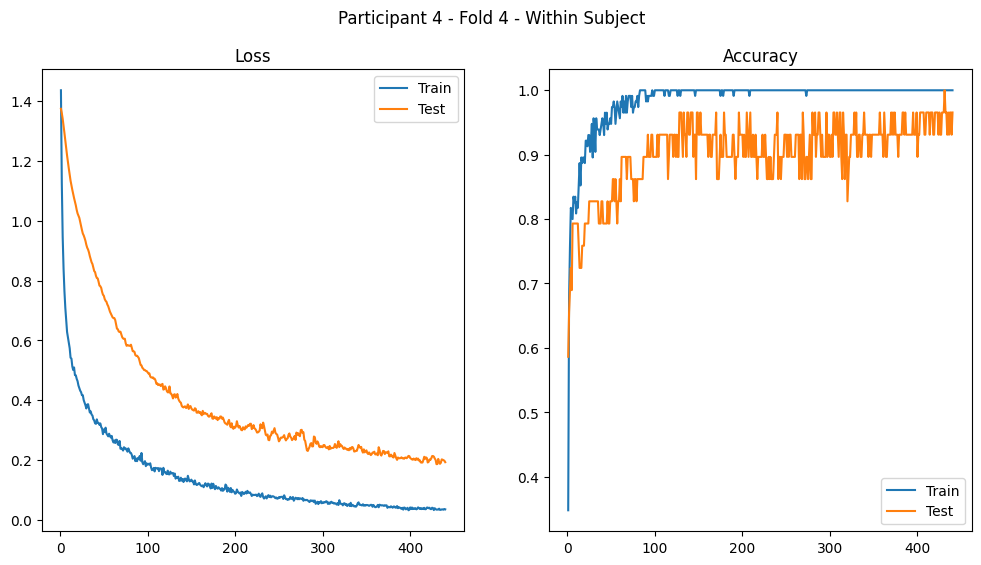

Outer Loop 5 

      Train epochs' shape:                                (116, 22, 1000, 1)
      Test epochs' shape:                                 (28, 22, 1000, 1)
      Train labels' shape:                                (116, 4)
      Test labels' shape:                                 (28, 4)
      Train labels' shape (without encoding):             (116, 1)
      Test labels' shape (without encoding):              (28, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
4/4 [==============================] - 1s 152ms/step - loss: 1.4086 - accuracy: 0.3966 - val_loss: 1.3782 - val_accuracy: 0.4286
Epoch 2/500
4/4 [==============================] - 0s 30ms/step - loss: 1.1207 - accuracy: 0.7069 - val_loss: 1.3646 - val_accuracy: 0.5000
Epoch 3/500
4/4 [==============================] - 0s 30ms/step - loss: 0.9656 - accuracy: 0.7241 - val_loss: 1.3453 - val_accuracy: 0.4643
Epoch 4/500
4/4 [==============================] - 0s 31ms/step - loss: 0.8408 - accuracy: 0.7500 - val_loss: 1.32

<Figure size 640x480 with 0 Axes>

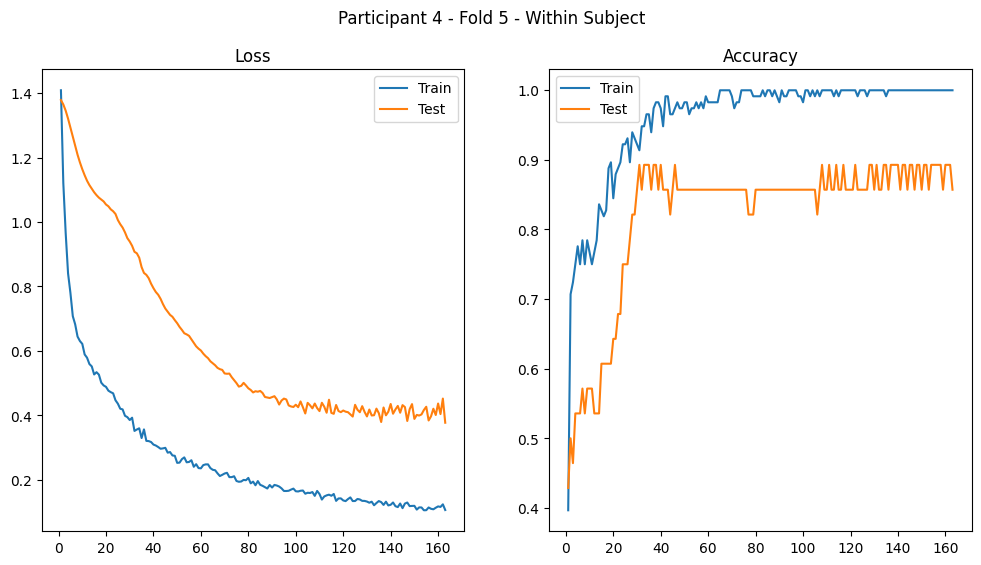

(288, 1)
Outer Loop 1 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 38ms/step - loss: 1.4129 - accuracy: 0.2348 - val_loss: 1.3864 - val_accuracy: 0.2759
Epoch 2/500
8/8 [==============================] - 0s 24ms/step - loss: 1.3101 - accuracy: 0.4957 - val_loss: 1.3851 - val_accuracy: 0.2759
Epoch 3/500
8/8 [==============================] - 0s 21ms/step - loss: 1.2281 - accuracy: 0.6043 - val_loss: 1.3830 - val_accuracy: 0.3448
Epoch 4/500
8/8 [==============================] - 0s 20ms/step - loss: 1.1593 - accuracy: 0.6478 - val_lo

<Figure size 640x480 with 0 Axes>

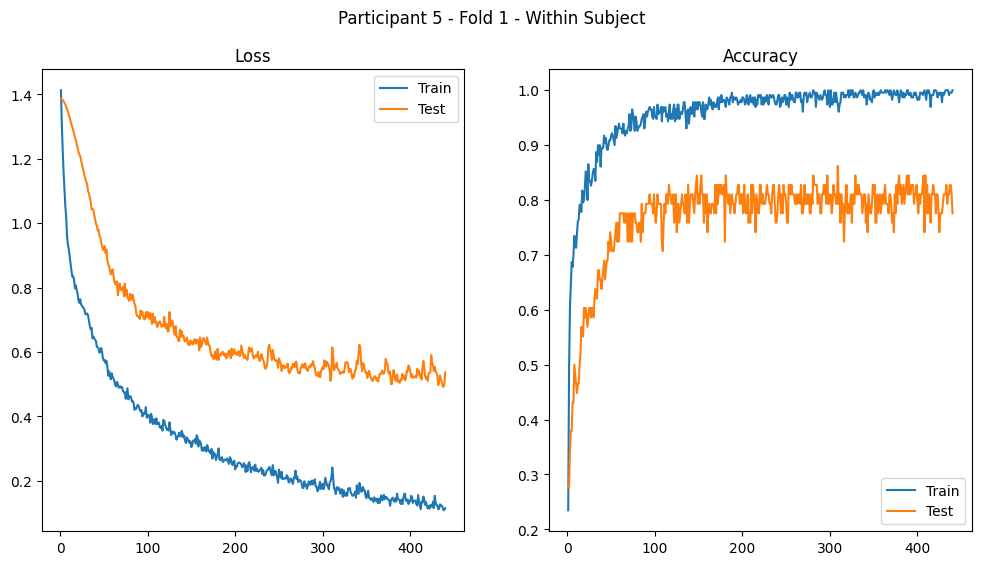

Outer Loop 2 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 52ms/step - loss: 1.4293 - accuracy: 0.2696 - val_loss: 1.3837 - val_accuracy: 0.3448
Epoch 2/500
8/8 [==============================] - 0s 25ms/step - loss: 1.3018 - accuracy: 0.4652 - val_loss: 1.3812 - val_accuracy: 0.4310
Epoch 3/500
8/8 [==============================] - 0s 23ms/step - loss: 1.2463 - accuracy: 0.5652 - val_loss: 1.3768 - val_accuracy: 0.5000
Epoch 4/500
8/8 [==============================] - 0s 20ms/step - loss: 1.1943 - accuracy: 0.6261 - val_loss: 1.372

<Figure size 640x480 with 0 Axes>

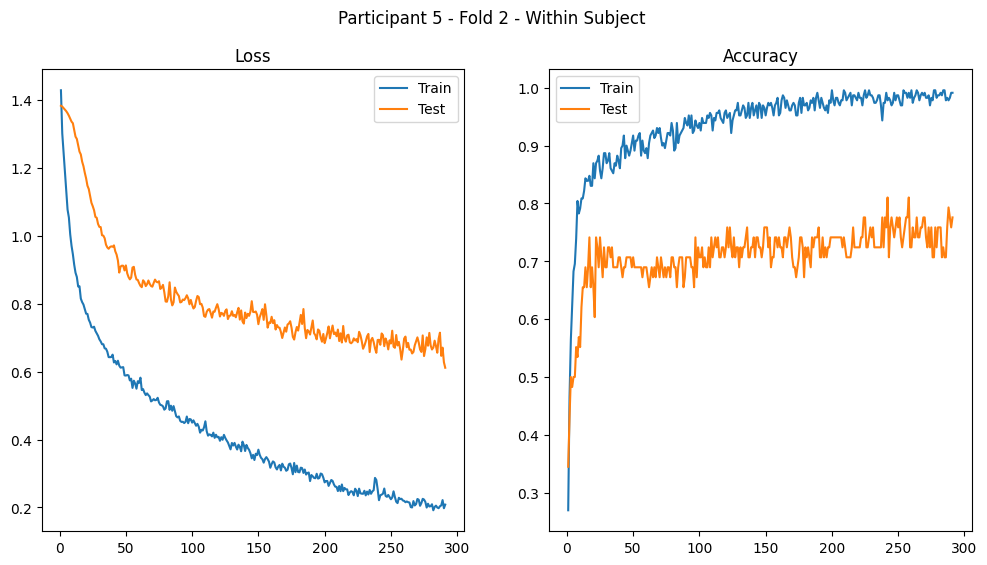

Outer Loop 3 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 47ms/step - loss: 1.3724 - accuracy: 0.3174 - val_loss: 1.3852 - val_accuracy: 0.2586
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2887 - accuracy: 0.5174 - val_loss: 1.3827 - val_accuracy: 0.2586
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2007 - accuracy: 0.6391 - val_loss: 1.3784 - val_accuracy: 0.3276
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.1300 - accuracy: 0.6348 - val_loss: 1.371

<Figure size 640x480 with 0 Axes>

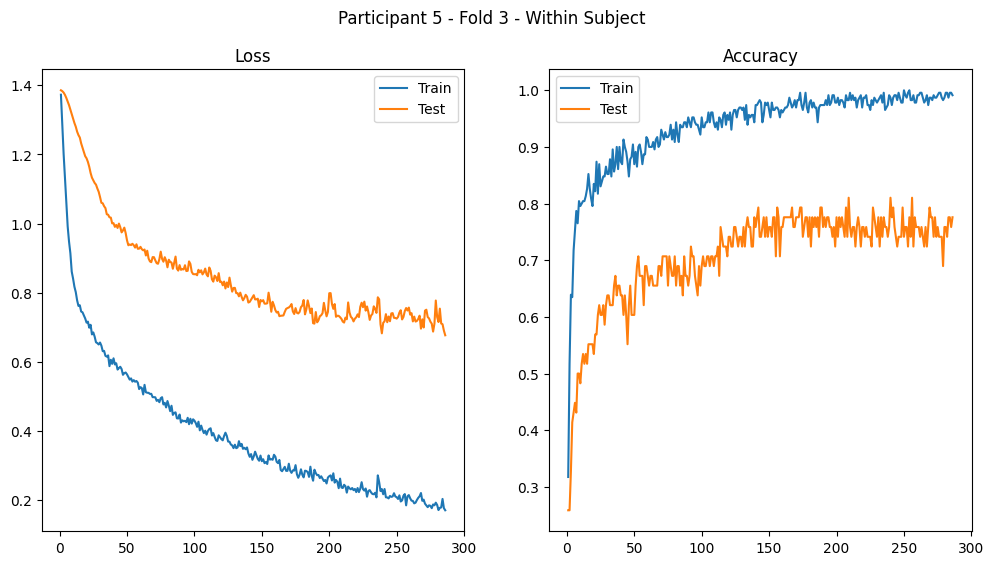

Outer Loop 4 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 44ms/step - loss: 1.4062 - accuracy: 0.2641 - val_loss: 1.3859 - val_accuracy: 0.2456
Epoch 2/500
8/8 [==============================] - 0s 21ms/step - loss: 1.3168 - accuracy: 0.4199 - val_loss: 1.3826 - val_accuracy: 0.3333
Epoch 3/500
8/8 [==============================] - 0s 18ms/step - loss: 1.2597 - accuracy: 0.5498 - val_loss: 1.3774 - val_accuracy: 0.4912
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2094 - accuracy: 0.5541 - val_loss: 1.371

<Figure size 640x480 with 0 Axes>

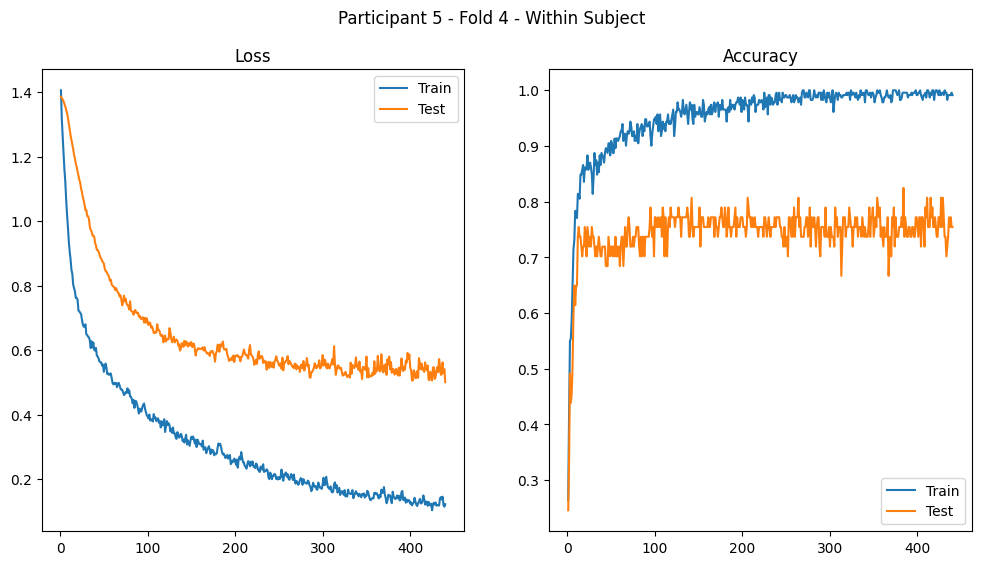

Outer Loop 5 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 37ms/step - loss: 1.4101 - accuracy: 0.2424 - val_loss: 1.3816 - val_accuracy: 0.2281
Epoch 2/500
8/8 [==============================] - 0s 21ms/step - loss: 1.3080 - accuracy: 0.3939 - val_loss: 1.3781 - val_accuracy: 0.2807
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2391 - accuracy: 0.5368 - val_loss: 1.3747 - val_accuracy: 0.3333
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.1900 - accuracy: 0.5368 - val_loss: 1.369

<Figure size 640x480 with 0 Axes>

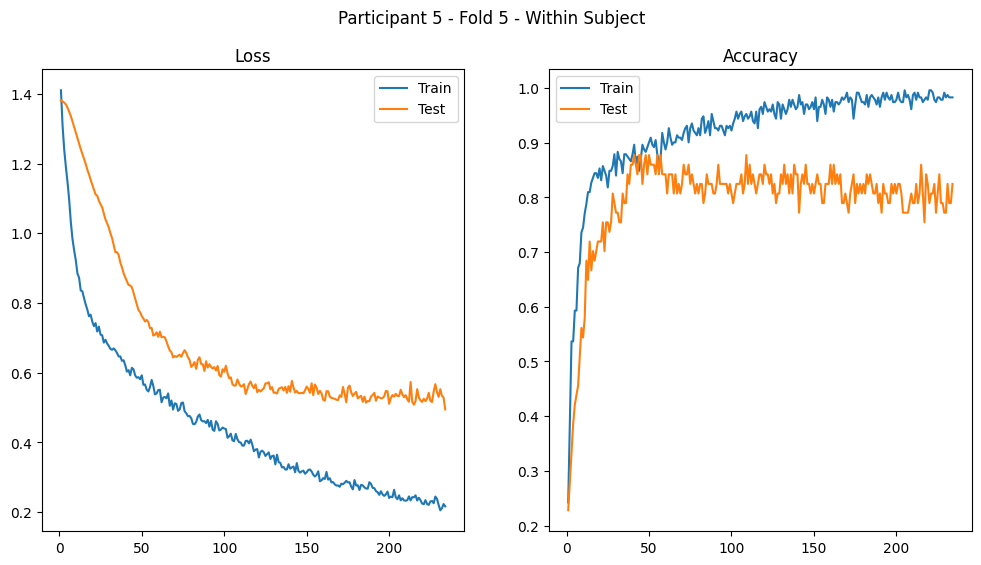

(288, 1)
Outer Loop 1 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 45ms/step - loss: 1.4170 - accuracy: 0.2130 - val_loss: 1.3852 - val_accuracy: 0.2069
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.3462 - accuracy: 0.4000 - val_loss: 1.3830 - val_accuracy: 0.3276
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.3157 - accuracy: 0.4870 - val_loss: 1.3809 - val_accuracy: 0.3448
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2810 - accuracy: 0.4957 - val_lo

<Figure size 640x480 with 0 Axes>

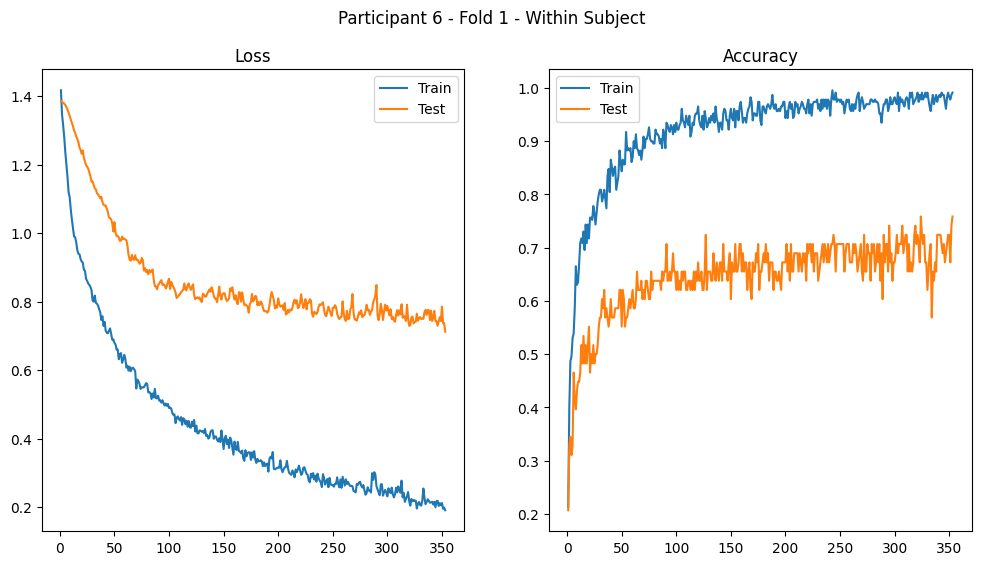

Outer Loop 2 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 48ms/step - loss: 1.4196 - accuracy: 0.2870 - val_loss: 1.3856 - val_accuracy: 0.2414
Epoch 2/500
8/8 [==============================] - 0s 20ms/step - loss: 1.3143 - accuracy: 0.4565 - val_loss: 1.3834 - val_accuracy: 0.4138
Epoch 3/500
8/8 [==============================] - 0s 21ms/step - loss: 1.2698 - accuracy: 0.4957 - val_loss: 1.3801 - val_accuracy: 0.4483
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2370 - accuracy: 0.5478 - val_loss: 1.375

<Figure size 640x480 with 0 Axes>

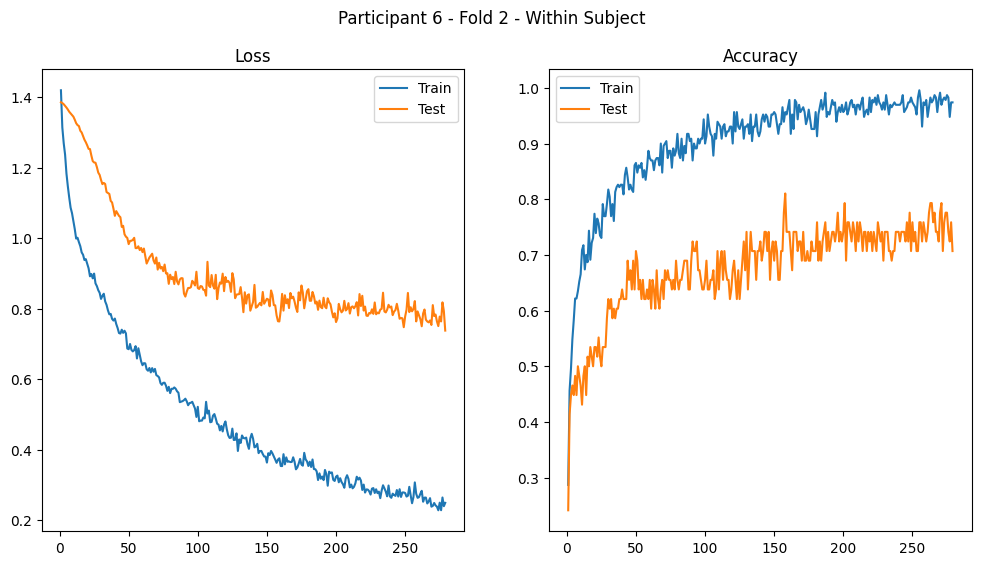

Outer Loop 3 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 45ms/step - loss: 1.4282 - accuracy: 0.2739 - val_loss: 1.3854 - val_accuracy: 0.2241
Epoch 2/500
8/8 [==============================] - 0s 25ms/step - loss: 1.3264 - accuracy: 0.4348 - val_loss: 1.3840 - val_accuracy: 0.2759
Epoch 3/500
8/8 [==============================] - 0s 23ms/step - loss: 1.2777 - accuracy: 0.4870 - val_loss: 1.3818 - val_accuracy: 0.2931
Epoch 4/500
8/8 [==============================] - 0s 21ms/step - loss: 1.2330 - accuracy: 0.5348 - val_loss: 1.378

<Figure size 640x480 with 0 Axes>

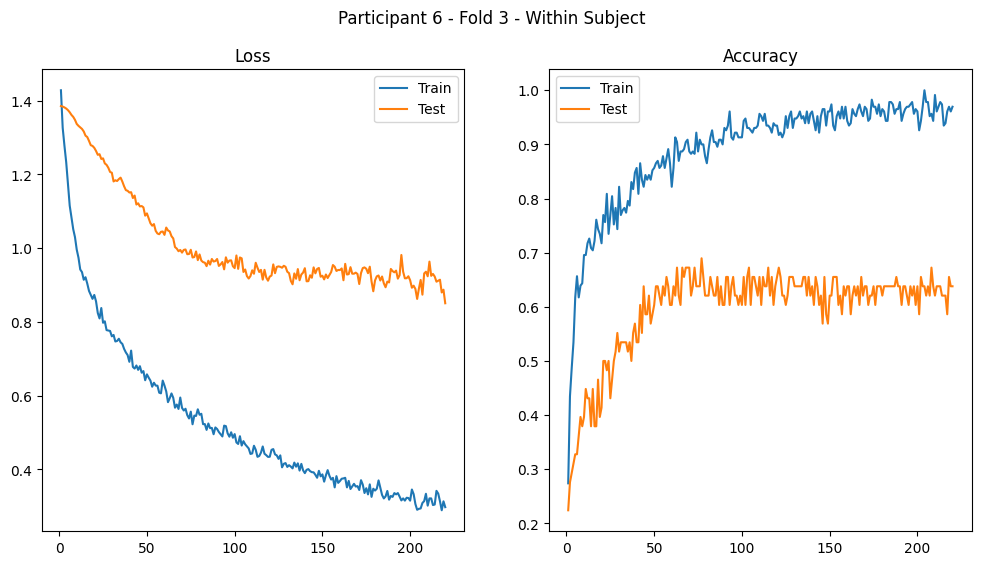

Outer Loop 4 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 42ms/step - loss: 1.4038 - accuracy: 0.2165 - val_loss: 1.3841 - val_accuracy: 0.4035
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.3196 - accuracy: 0.4805 - val_loss: 1.3814 - val_accuracy: 0.4737
Epoch 3/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2660 - accuracy: 0.5887 - val_loss: 1.3760 - val_accuracy: 0.5439
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2043 - accuracy: 0.5931 - val_loss: 1.370

<Figure size 640x480 with 0 Axes>

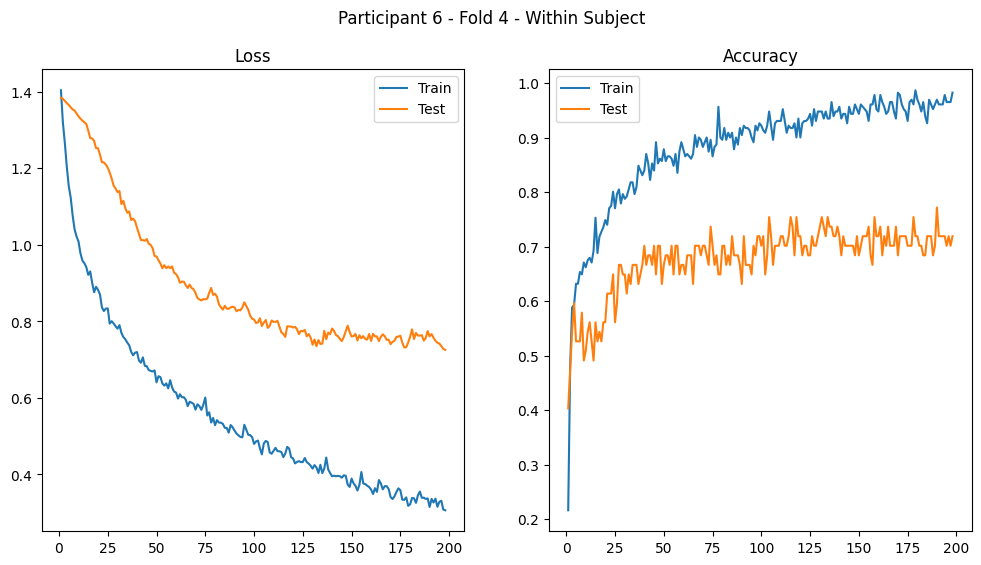

Outer Loop 5 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 45ms/step - loss: 1.4166 - accuracy: 0.2554 - val_loss: 1.3856 - val_accuracy: 0.2632
Epoch 2/500
8/8 [==============================] - 0s 18ms/step - loss: 1.3255 - accuracy: 0.4156 - val_loss: 1.3845 - val_accuracy: 0.2982
Epoch 3/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2783 - accuracy: 0.4459 - val_loss: 1.3829 - val_accuracy: 0.3333
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2274 - accuracy: 0.5325 - val_loss: 1.381

<Figure size 640x480 with 0 Axes>

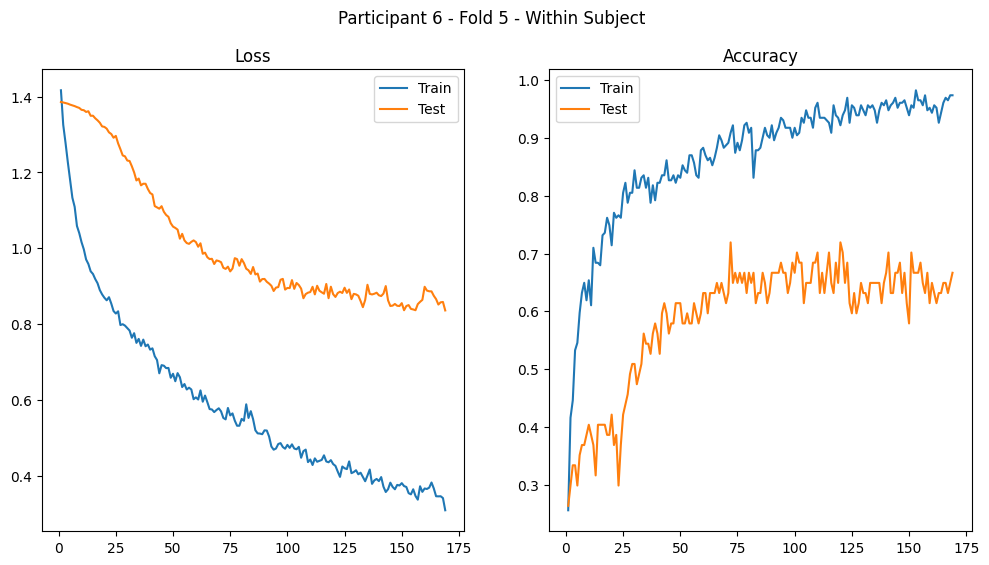

(288, 1)
Outer Loop 1 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 56ms/step - loss: 1.4113 - accuracy: 0.2348 - val_loss: 1.3852 - val_accuracy: 0.3276
Epoch 2/500
8/8 [==============================] - 0s 24ms/step - loss: 1.3398 - accuracy: 0.4652 - val_loss: 1.3831 - val_accuracy: 0.2241
Epoch 3/500
8/8 [==============================] - 0s 22ms/step - loss: 1.2961 - accuracy: 0.5348 - val_loss: 1.3798 - val_accuracy: 0.3103
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2487 - accuracy: 0.5652 - val_lo

<Figure size 640x480 with 0 Axes>

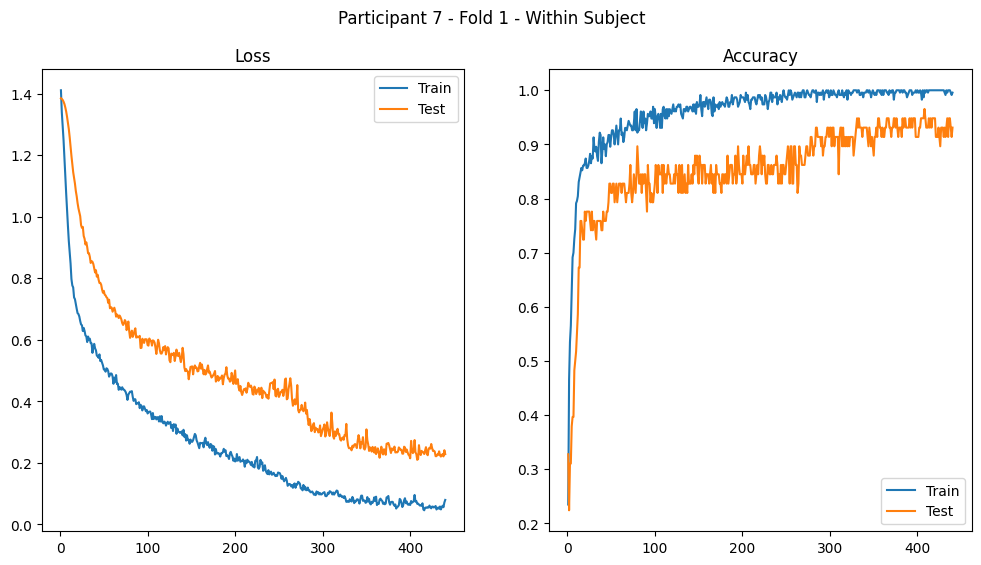

Outer Loop 2 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 44ms/step - loss: 1.4085 - accuracy: 0.3000 - val_loss: 1.3841 - val_accuracy: 0.3103
Epoch 2/500
8/8 [==============================] - 0s 20ms/step - loss: 1.3040 - accuracy: 0.5261 - val_loss: 1.3806 - val_accuracy: 0.3793
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2320 - accuracy: 0.6348 - val_loss: 1.3734 - val_accuracy: 0.3793
Epoch 4/500
8/8 [==============================] - 0s 18ms/step - loss: 1.1549 - accuracy: 0.6478 - val_loss: 1.363

<Figure size 640x480 with 0 Axes>

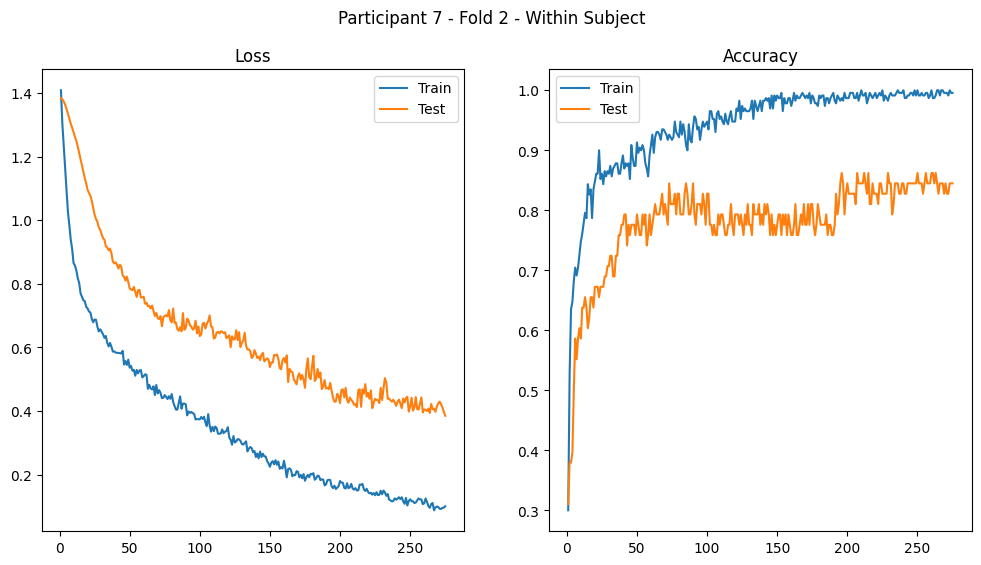

Outer Loop 3 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 38ms/step - loss: 1.4051 - accuracy: 0.2565 - val_loss: 1.3834 - val_accuracy: 0.3448
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.3047 - accuracy: 0.4565 - val_loss: 1.3784 - val_accuracy: 0.3448
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2451 - accuracy: 0.5565 - val_loss: 1.3709 - val_accuracy: 0.3793
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.1779 - accuracy: 0.5870 - val_loss: 1.360

<Figure size 640x480 with 0 Axes>

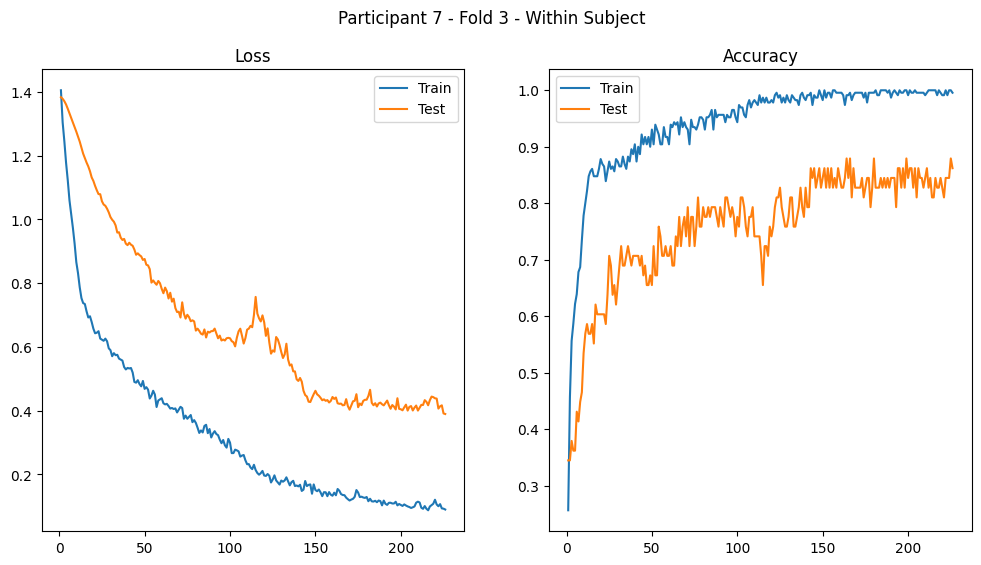

Outer Loop 4 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 44ms/step - loss: 1.3835 - accuracy: 0.3074 - val_loss: 1.3840 - val_accuracy: 0.2632
Epoch 2/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2965 - accuracy: 0.5065 - val_loss: 1.3790 - val_accuracy: 0.3509
Epoch 3/500
8/8 [==============================] - 0s 21ms/step - loss: 1.2203 - accuracy: 0.6190 - val_loss: 1.3710 - val_accuracy: 0.3860
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.1452 - accuracy: 0.6537 - val_loss: 1.358

<Figure size 640x480 with 0 Axes>

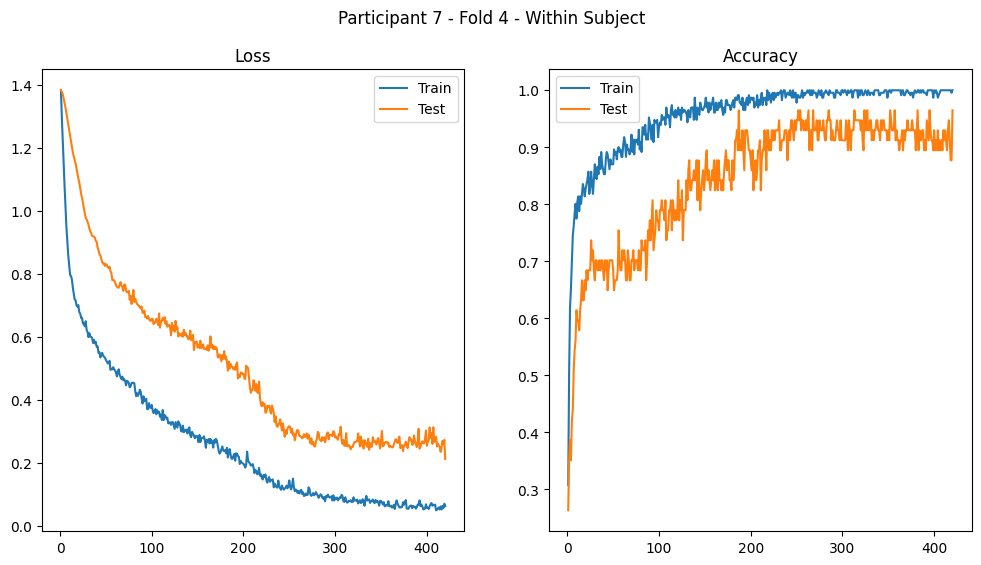

Outer Loop 5 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 45ms/step - loss: 1.4062 - accuracy: 0.2554 - val_loss: 1.3831 - val_accuracy: 0.2632
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2859 - accuracy: 0.5325 - val_loss: 1.3788 - val_accuracy: 0.2982
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2046 - accuracy: 0.6061 - val_loss: 1.3707 - val_accuracy: 0.3333
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.1098 - accuracy: 0.6753 - val_loss: 1.361

<Figure size 640x480 with 0 Axes>

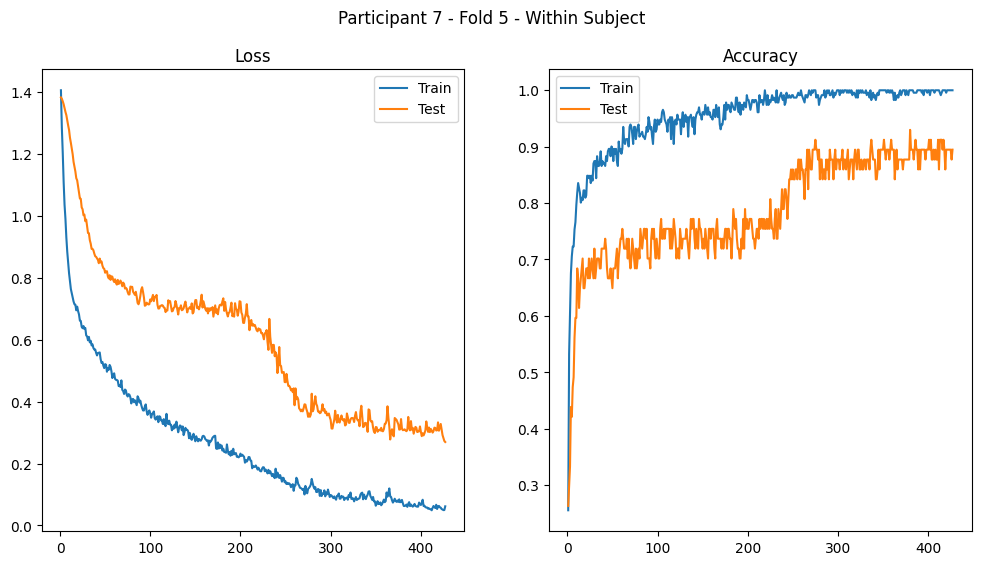

(288, 1)
Outer Loop 1 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 45ms/step - loss: 1.3857 - accuracy: 0.3217 - val_loss: 1.3844 - val_accuracy: 0.3276
Epoch 2/500
8/8 [==============================] - 0s 18ms/step - loss: 1.3025 - accuracy: 0.5348 - val_loss: 1.3816 - val_accuracy: 0.3966
Epoch 3/500
8/8 [==============================] - 0s 18ms/step - loss: 1.2344 - accuracy: 0.5783 - val_loss: 1.3771 - val_accuracy: 0.3966
Epoch 4/500
8/8 [==============================] - 0s 17ms/step - loss: 1.1977 - accuracy: 0.5913 - val_lo

<Figure size 640x480 with 0 Axes>

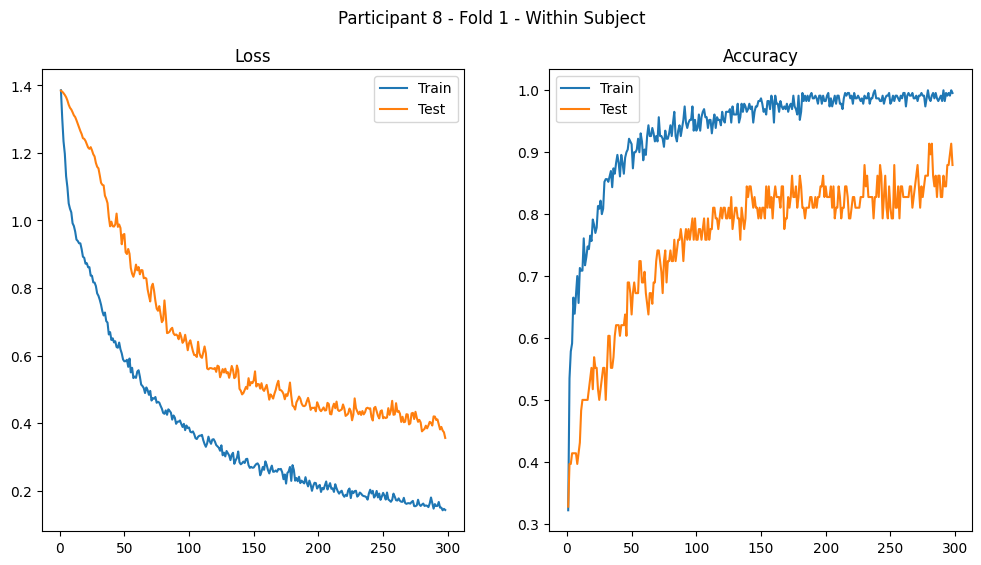

Outer Loop 2 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 46ms/step - loss: 1.3921 - accuracy: 0.2652 - val_loss: 1.3850 - val_accuracy: 0.3448
Epoch 2/500
8/8 [==============================] - 0s 20ms/step - loss: 1.3308 - accuracy: 0.4739 - val_loss: 1.3833 - val_accuracy: 0.3966
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2820 - accuracy: 0.5565 - val_loss: 1.3804 - val_accuracy: 0.3966
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2167 - accuracy: 0.6348 - val_loss: 1.375

<Figure size 640x480 with 0 Axes>

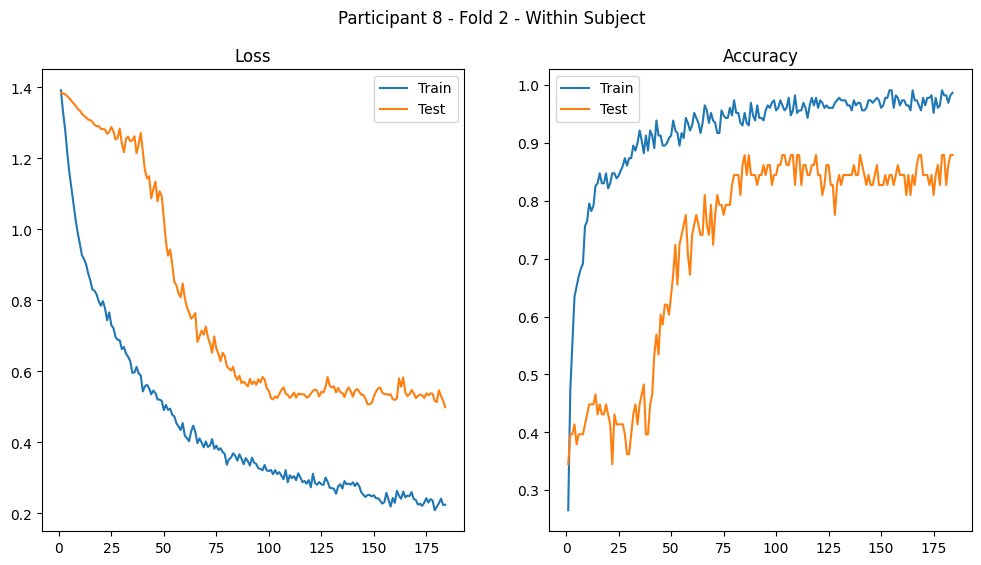

Outer Loop 3 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 45ms/step - loss: 1.4315 - accuracy: 0.2174 - val_loss: 1.3847 - val_accuracy: 0.3276
Epoch 2/500
8/8 [==============================] - 0s 18ms/step - loss: 1.3394 - accuracy: 0.4304 - val_loss: 1.3818 - val_accuracy: 0.3621
Epoch 3/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2812 - accuracy: 0.5174 - val_loss: 1.3768 - val_accuracy: 0.3966
Epoch 4/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2116 - accuracy: 0.6478 - val_loss: 1.369

<Figure size 640x480 with 0 Axes>

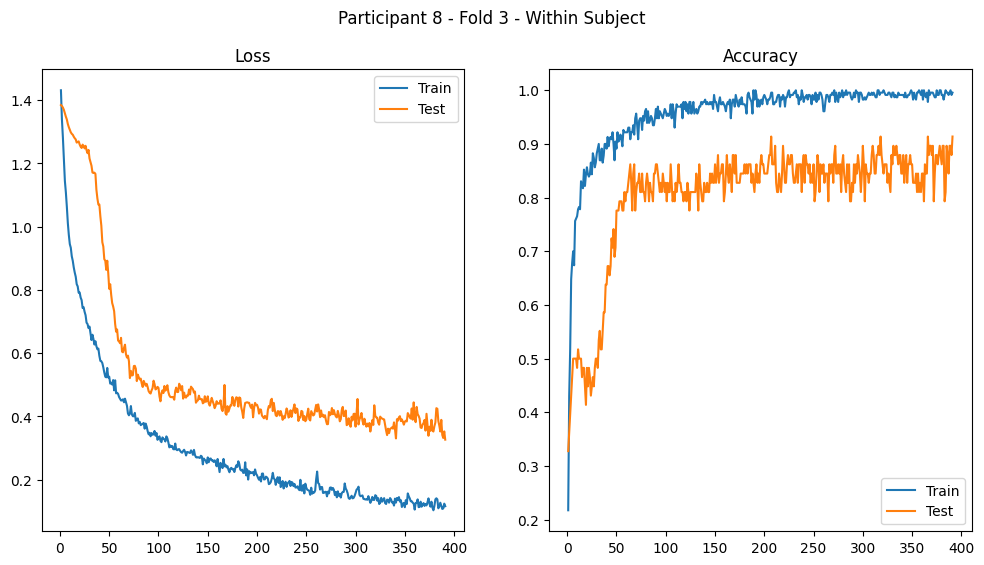

Outer Loop 4 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 2s 52ms/step - loss: 1.3717 - accuracy: 0.3074 - val_loss: 1.3838 - val_accuracy: 0.4737
Epoch 2/500
8/8 [==============================] - 0s 26ms/step - loss: 1.2979 - accuracy: 0.5152 - val_loss: 1.3799 - val_accuracy: 0.4386
Epoch 3/500
8/8 [==============================] - 0s 22ms/step - loss: 1.2257 - accuracy: 0.6450 - val_loss: 1.3744 - val_accuracy: 0.4386
Epoch 4/500
8/8 [==============================] - 0s 21ms/step - loss: 1.1546 - accuracy: 0.7100 - val_loss: 1.367

<Figure size 640x480 with 0 Axes>

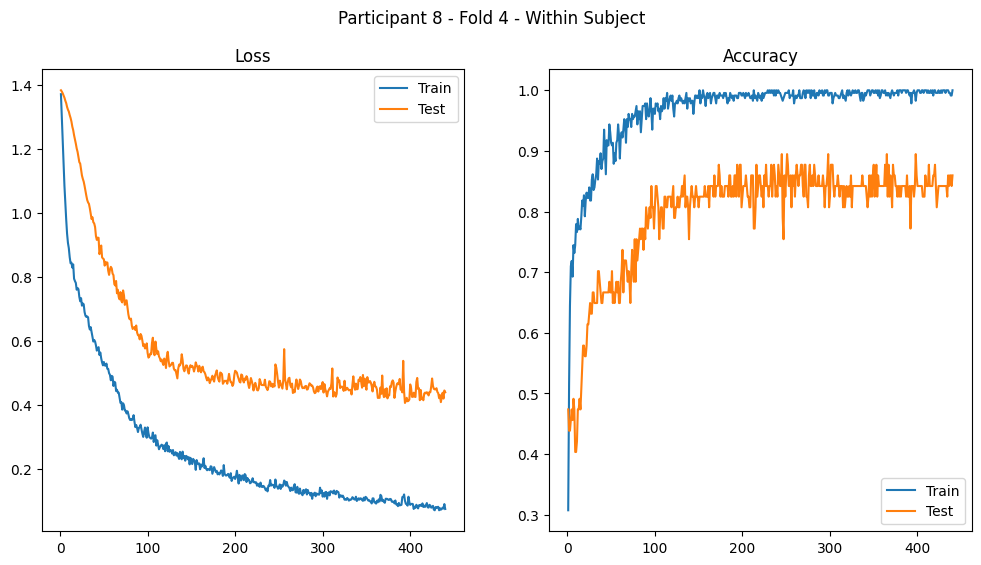

Outer Loop 5 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 39ms/step - loss: 1.4003 - accuracy: 0.3160 - val_loss: 1.3840 - val_accuracy: 0.3860
Epoch 2/500
8/8 [==============================] - 0s 21ms/step - loss: 1.3043 - accuracy: 0.5065 - val_loss: 1.3809 - val_accuracy: 0.4035
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2543 - accuracy: 0.5931 - val_loss: 1.3762 - val_accuracy: 0.4737
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.1841 - accuracy: 0.6667 - val_loss: 1.369

<Figure size 640x480 with 0 Axes>

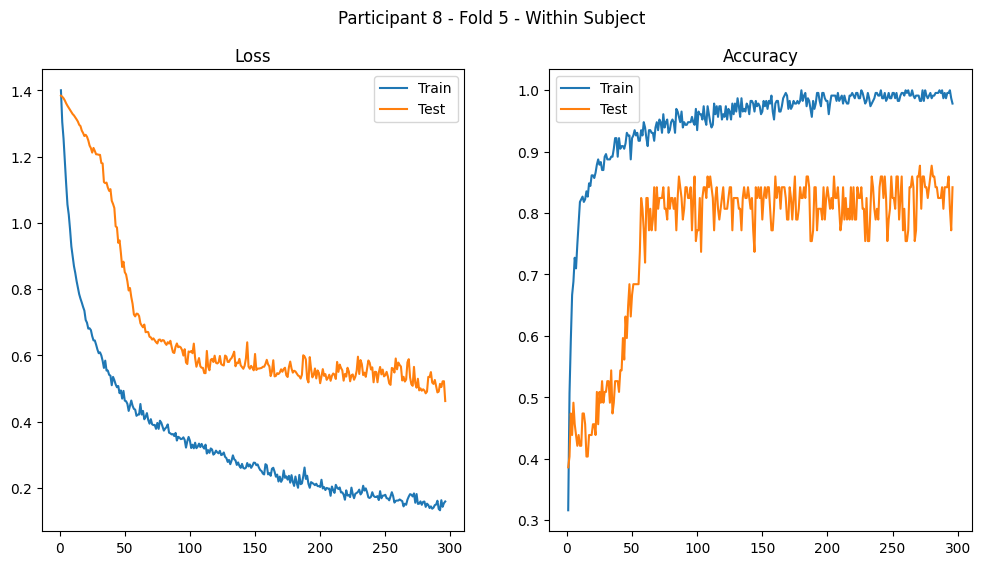

(288, 1)
Outer Loop 1 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 44ms/step - loss: 1.4178 - accuracy: 0.2478 - val_loss: 1.3861 - val_accuracy: 0.2759
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.3253 - accuracy: 0.4652 - val_loss: 1.3821 - val_accuracy: 0.2586
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2625 - accuracy: 0.5130 - val_loss: 1.3768 - val_accuracy: 0.3448
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2052 - accuracy: 0.6130 - val_lo

<Figure size 640x480 with 0 Axes>

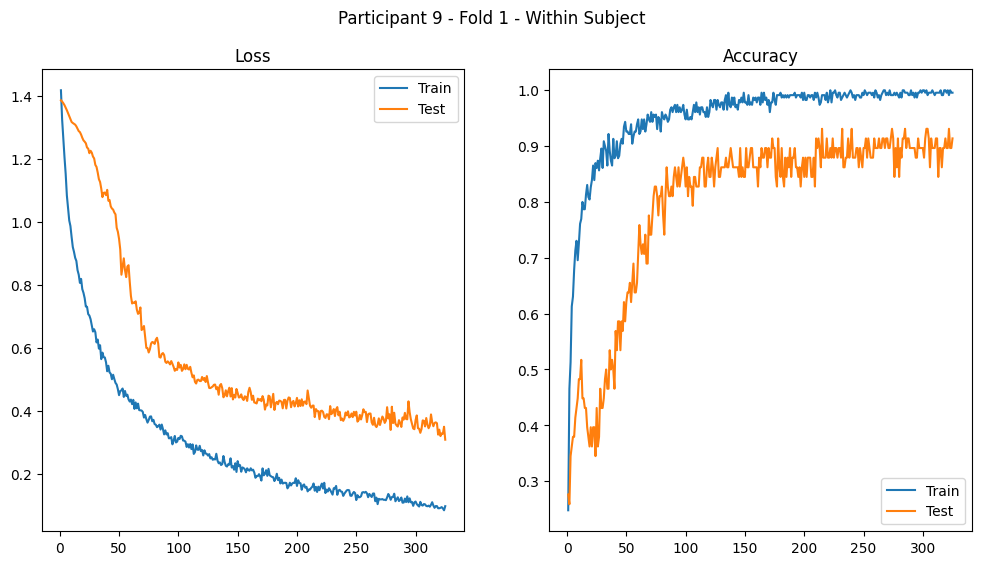

Outer Loop 2 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 49ms/step - loss: 1.4090 - accuracy: 0.2565 - val_loss: 1.3850 - val_accuracy: 0.2931
Epoch 2/500
8/8 [==============================] - 0s 23ms/step - loss: 1.3148 - accuracy: 0.4696 - val_loss: 1.3812 - val_accuracy: 0.3793
Epoch 3/500
8/8 [==============================] - 0s 23ms/step - loss: 1.2643 - accuracy: 0.6217 - val_loss: 1.3767 - val_accuracy: 0.4310
Epoch 4/500
8/8 [==============================] - 0s 22ms/step - loss: 1.2091 - accuracy: 0.6696 - val_loss: 1.371

<Figure size 640x480 with 0 Axes>

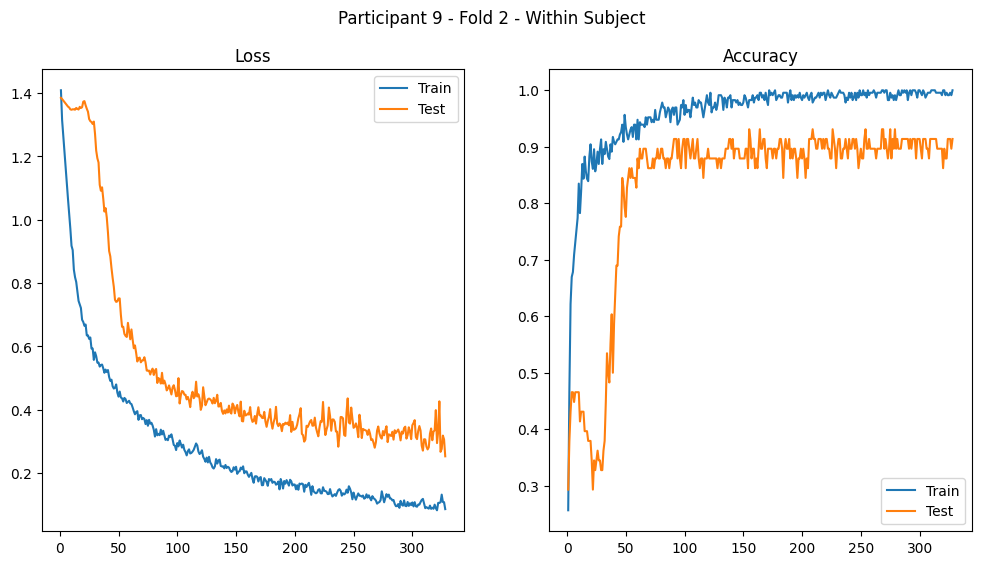

Outer Loop 3 

      Train epochs' shape:                                (230, 22, 1000, 1)
      Test epochs' shape:                                 (58, 22, 1000, 1)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 43ms/step - loss: 1.4274 - accuracy: 0.2174 - val_loss: 1.3837 - val_accuracy: 0.2586
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.3183 - accuracy: 0.4435 - val_loss: 1.3789 - val_accuracy: 0.3103
Epoch 3/500
8/8 [==============================] - 0s 21ms/step - loss: 1.2486 - accuracy: 0.5565 - val_loss: 1.3744 - val_accuracy: 0.3448
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.1934 - accuracy: 0.6565 - val_loss: 1.370

<Figure size 640x480 with 0 Axes>

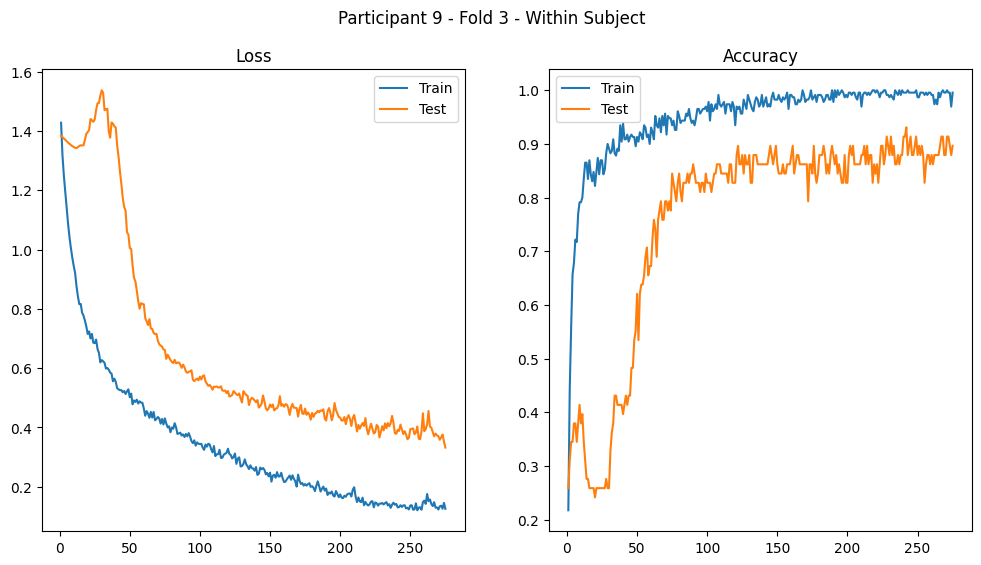

Outer Loop 4 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 44ms/step - loss: 1.3718 - accuracy: 0.3636 - val_loss: 1.3834 - val_accuracy: 0.3684
Epoch 2/500
8/8 [==============================] - 0s 21ms/step - loss: 1.3101 - accuracy: 0.4848 - val_loss: 1.3807 - val_accuracy: 0.3509
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 1.2579 - accuracy: 0.6104 - val_loss: 1.3771 - val_accuracy: 0.3684
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.1905 - accuracy: 0.7013 - val_loss: 1.370

<Figure size 640x480 with 0 Axes>

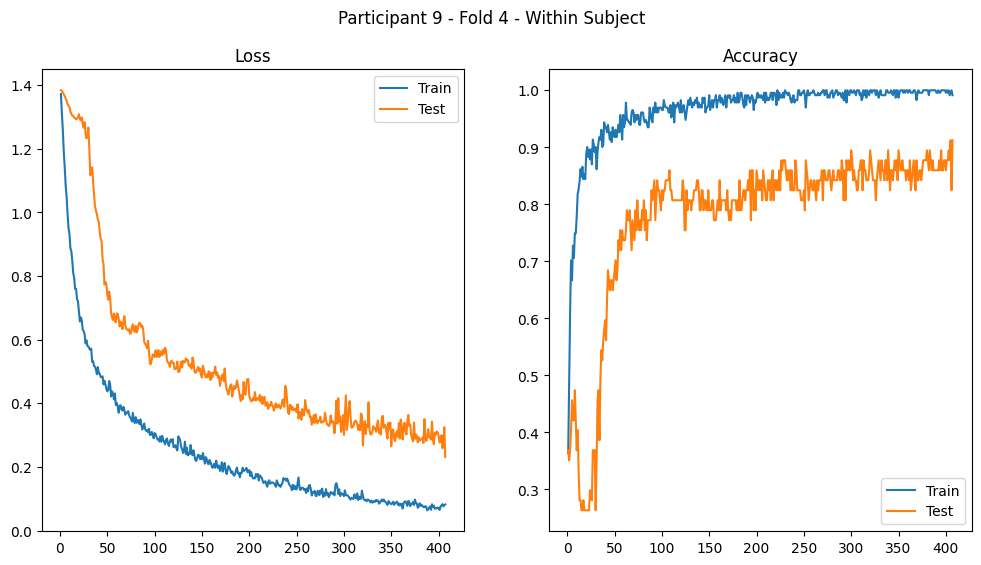

Outer Loop 5 

      Train epochs' shape:                                (231, 22, 1000, 1)
      Test epochs' shape:                                 (57, 22, 1000, 1)
      Train labels' shape:                                (231, 4)
      Test labels' shape:                                 (57, 4)
      Train labels' shape (without encoding):             (231, 1)
      Test labels' shape (without encoding):              (57, 1)



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
8/8 [==============================] - 1s 37ms/step - loss: 1.3941 - accuracy: 0.2857 - val_loss: 1.3840 - val_accuracy: 0.3333
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 1.2967 - accuracy: 0.4978 - val_loss: 1.3808 - val_accuracy: 0.4386
Epoch 3/500
8/8 [==============================] - 0s 18ms/step - loss: 1.2294 - accuracy: 0.5974 - val_loss: 1.3770 - val_accuracy: 0.4912
Epoch 4/500
8/8 [==============================] - 0s 18ms/step - loss: 1.1676 - accuracy: 0.6623 - val_loss: 1.372

<Figure size 640x480 with 0 Axes>

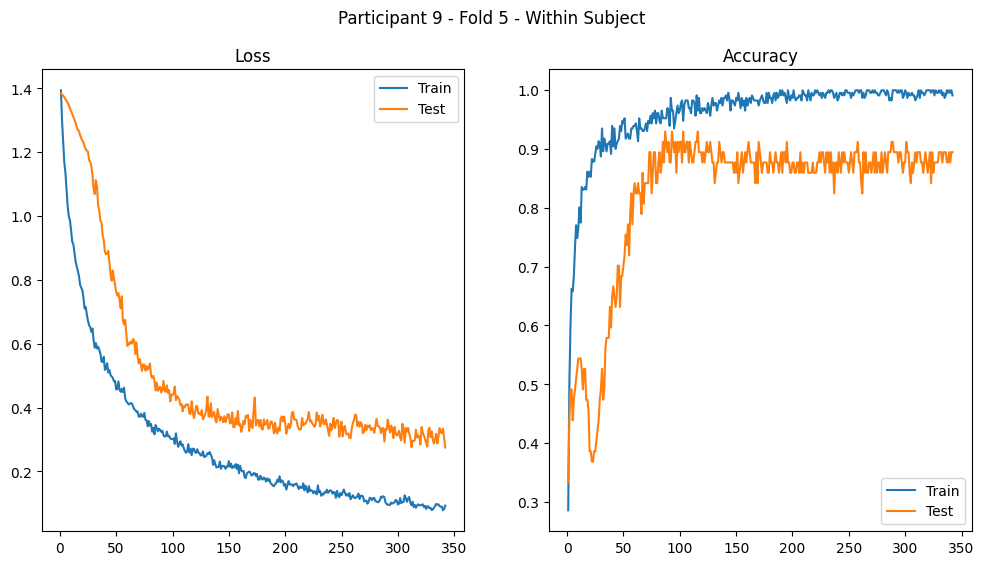

<Figure size 640x480 with 0 Axes>

In [86]:
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0009




for j in range(num_subjects):
    
    epochs_subject = all_data_epochs[j]
    labels_subject = encoded[j]
    labels_subject_no_encode = no_encode[j]
    
    print(labels_subject_no_encode.shape)
    
    kf_outer2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    tests_pred = []
    tests_true = []
    
    for i, (train_index, test_index) in enumerate(kf_outer2.split(epochs_subject, labels_subject_no_encode[:, 0])):



        train_epochs = np.array([epochs_subject[j] for j in train_index])
        test_epochs = np.array([epochs_subject[k] for k in test_index])
        train_labels = np.array([labels_subject[l] for l in train_index])
        test_labels = np.array([labels_subject[m] for m in test_index])
        no_encoded_train_labels = np.array([labels_subject_no_encode[n] for n in train_index])
        no_encoded_test_labels = np.array([labels_subject_no_encode[o] for o in test_index])
        


        print("Outer Loop {}".format(i+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        print("      Train labels' shape:                               ", train_labels.shape)
        print("      Test labels' shape:                                ", test_labels.shape)
        print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

        print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)

        print('\n\n')


        # Create the EEGNet model
        model = EEGNet(nb_classes=4, Chans=22, Samples=1000, dropoutRate=0.25, kernLength=22, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout')

        # Compile the model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        patience = 60
        train_loss_epochs = []
        train_acc_epochs = []
        test_loss_epochs = []
        test_acc_epochs = []
        train_conf_mat = []

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


        # Normalizing the features
        mean = train_epochs.mean(axis=(0, 2), keepdims=True)
        std = train_epochs.std(axis=(0, 2), keepdims=True)

        print(mean.shape)
        print(std.shape)

        norm_train_epochs = (train_epochs - mean) / std
        norm_test_epochs = (test_epochs - mean) / std
        

        # Train the model
        history = model.fit(
            norm_train_epochs, train_labels,
            validation_data=(norm_test_epochs, test_labels),
            epochs=max_epochs,
            batch_size=32,  # Adjust as needed
            callbacks=[early_stopping]
        )

        y_pred_test = model.predict(norm_test_epochs)
        y_true_test = test_labels

        

        # Collect training metrics
        train_loss_epochs.extend(history.history['loss'])
        train_acc_epochs.extend(history.history['accuracy'])

        # Collect testing metrics
        test_loss_epochs.extend(history.history['val_loss'])
        test_acc_epochs.extend(history.history['val_accuracy'])

        epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)

        plt.figure(figsize=(12, 6))
        plt.suptitle("Participant {} - Fold {} - Within Subject".format(j+1, i+1))

        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(epochs_range, train_loss_epochs[:-1*patience])
        plt.plot(epochs_range, test_loss_epochs[:-1*patience])
        plt.legend(["Train", "Test"])

        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(epochs_range, train_acc_epochs[:-1*patience])
        plt.plot(epochs_range, test_acc_epochs[:-1*patience])
        plt.legend(["Train", "Test"])
        plt.savefig("P{}_F{}_WS.jpg".format(j+1, i+1))
        plt.show()
        plt.clf()
        
        tests_pred.extend(y_pred_test)
        tests_true.extend(y_true_test)
    
    with open("y_pred_ParID_{}_ws.pickle".format(j+1), 'wb') as f:
        pickle.dump(tests_pred, f)

    with open("y_true_ParID_{}_ws.pickle".format(j+1), 'wb') as f:
        pickle.dump(tests_true, f)
        
    all_tests_pred.append(tests_pred)
    all_tests_true.append(tests_true)


In [83]:
participants[0]

1

In [ ]:
print(len(all_tests_pred))

In [20]:
print(np.concatenate(all_tests_pred[4]).shape)

(288,)


In [94]:
confusion_matrices = []
all_y_pred = []
all_y_true = []

for i in range(1, 10):
    
    with open("y_pred_ParID_{}_ws.pickle".format(i), 'rb') as f:
        all_y_pred.append(pickle.load(f))
        
        
    with open("y_true_ParID_{}_ws.pickle".format(i), 'rb') as f:
        all_y_true.append(pickle.load(f))
    
    y_true = np.array(all_y_true[i-1])
    y_pred = np.array(all_y_pred[i-1])
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [97]:
confusion_matrices[3]

array([[61, 11],
       [ 7, 65]])

In [98]:
del confusion_matrices[3]

In [99]:
confusion_matrices[3]

array([[63,  1,  5,  3],
       [ 1, 60,  1, 10],
       [ 5,  4, 56,  7],
       [ 3,  7, 13, 49]])

In [90]:
print(confusion_matrices[1])

[[44 14  9  5]
 [14 36 11 11]
 [ 5  3 60  4]
 [ 7  6  2 57]]


In [91]:
print(len(confusion_matrices))

9


In [100]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)'])
normalized = summation.div(summation.sum(axis=1), axis=0)
acc = normalized.values.trace() / 4


In [101]:
print("Dataset: BCI-IV 2a")
print("The within-subject scenario:")
print("Algorithm: EEGNet")
print("Accuracy: ", acc)

normalized

Dataset: BCI-IV 2a
The within-subject scenario:
Algorithm: EEGNet
Accuracy:  0.8285590277777778


Left (Pred)  Right (Pred)  Feet (Pred)  Tongue (Pred)
Left (True)       0.833333      0.057292     0.064236       0.045139
Right (True)      0.046875      0.838542     0.053819       0.060764
Feet (True)       0.046875      0.064236     0.803819       0.085069
Tongue (True)     0.052083      0.034722     0.074653       0.838542

In [26]:
summation.sum(axis=1)

Left (True)      576
Right (True)     576
Feet (True)      576
Tongue (True)    576
dtype: int64

In [27]:
np.sum(summation / 576 * np.eye(4, 4)).sum() / 4

C:\ProgramData\Anaconda3\envs\BCI_2\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0.74609375

# Cross-subjects (WO hyperparameter tuning):

In [ ]:
participants = [1, 2, 3, 4, 5, 6, 7, 8, 9]
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0009



kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.



for i, (train_index, test_index) in enumerate(kf_outer2.split(all_data_epochs)):
    
    
    
    train_epochs = np.concatenate([all_data_epochs[j] for j in train_index])
    test_epochs = np.concatenate([all_data_epochs[k] for k in test_index])
    train_labels = np.concatenate([encoded[l] for l in train_index])
    test_labels = np.concatenate([encoded[m] for m in test_index])
    no_encoded_train_labels = np.concatenate([no_encode[n] for n in train_index])
    no_encoded_test_labels = np.concatenate([no_encode[o] for o in test_index])
    train_ids_for_save = [participants[i] for i in train_index]
    test_ids_for_save = [participants[i] for i in test_index]
    
    
    print("Outer Loop {}".format(i+1), "\n")
    print("      Train epochs' shape:                               ", train_epochs.shape)

    print("      Test epochs' shape:                                ", test_epochs.shape)
    print("      Test labels' shape:                                ", test_labels.shape)
    print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

    print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)
    print("      Train index:                                       ", train_ids_for_save)

    print("      Test index:                                        ", test_ids_for_save)
    print('\n\n')
    
    
    # Create the EEGNet model
    model = EEGNet(nb_classes=4, Chans=22, Samples=1000, dropoutRate=0.25, kernLength=22, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout')

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    patience = 60
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    train_conf_mat = []
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    
    # Normalizing the features
    mean = train_epochs.mean(axis=(0, 2, 3), keepdims=True)
    std = train_epochs.std(axis=(0, 2, 3), keepdims=True)
    
    print(mean.shape)
    print(std.shape)
    
    norm_train_epochs = (train_epochs - mean) / std
    norm_test_epochs = (test_epochs - mean) / std
    
    
    
    
    # Train the model
    history = model.fit(
        norm_train_epochs, train_labels,
        validation_data=(norm_test_epochs, test_labels),
        epochs=max_epochs,
        batch_size=32,  # Adjust as needed
        callbacks=[early_stopping]
    )
    
    y_pred_test = model.predict(norm_test_epochs)
    y_true_test = test_labels
    
    with open("y_pred_testID_{}.pickle".format(participants[test_index[0]]), 'wb') as f:
        pickle.dump(y_pred_test, f)
    
    with open("y_true_testID_{}.pickle".format(participants[test_index[0]]), 'wb') as f:
        pickle.dump(y_true_test, f)
    
    # Collect training metrics
    train_loss_epochs.extend(history.history['loss'])
    train_acc_epochs.extend(history.history['accuracy'])

    # Collect testing metrics
    test_loss_epochs.extend(history.history['val_loss'])
    test_acc_epochs.extend(history.history['val_accuracy'])
    
    epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)
    
    plt.figure(figsize=(12, 6))
    plt.suptitle("Participant {}".format(participants[test_index[0]]))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(epochs_range, train_loss_epochs[:-1*patience])
    plt.plot(epochs_range, test_loss_epochs[:-1*patience])
    plt.legend(["Train", "Test"])

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(epochs_range, train_acc_epochs[:-1*patience])
    plt.plot(epochs_range, test_acc_epochs[:-1*patience])
    plt.legend(["Train", "Test"])
    plt.savefig("P{}.jpg".format(participants[test_index[0]]))
    plt.show()
    plt.clf()

In [56]:
confusion_matrices = []
all_y_pred = []
all_y_true = []

for i in range(1, 10):
    with open("y_pred_testID_{}.pickle".format(i), 'rb') as f:
        all_y_pred.append(pickle.load(f))
        
        
    with open("y_true_testID_{}.pickle".format(i), 'rb') as f:
        all_y_true.append(pickle.load(f))
        
    y_true = all_y_true[i-1]
    y_pred = all_y_pred[i-1]
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [57]:
len(confusion_matrices)

9

In [66]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)'])
normalized = summation.div(summation.sum(axis=1), axis=0)
acc = normalized.values.trace() / 4


In [67]:
summation.sum(axis=1)

Left (True)      648
Right (True)     648
Feet (True)      576
Tongue (True)    576
dtype: int64

In [68]:
acc

0.6418306327160493

In [71]:
print("Dataset: BCI-IV 2a")
print("The cross-subject scenario:")
print("Algorithm: EEGNet")
print("Accuracy: ", acc)

normalized

Dataset: BCI-IV 2a
The cross-subject scenario:
Algorithm: EEGNet
Accuracy:  0.6418306327160493


Left (Pred)  Right (Pred)  Feet (Pred)  Tongue (Pred)
Left (True)       0.660494      0.152778     0.117284       0.069444
Right (True)      0.117284      0.675926     0.117284       0.089506
Feet (True)       0.163194      0.125000     0.621528       0.090278
Tongue (True)     0.147569      0.145833     0.097222       0.609375

In [72]:
np.argmax([1, 1, 2, 2, 3, 3, 3, 1])

4

# Test for the effect of calibration:

In [32]:
models = []
Calibrated_model = []
for file in os.listdir("/home/bijan/py3x"):
    if file.endswith(".h5") and file.startswith("Calibrated"):
        Calibrated_model.append(file)
    elif file.endswith(".h5") and file.startswith("Model"):
        models.append(file)
        
Calibrated_model = sorted(Calibrated_model)
models = sorted(models)

In [49]:
models = {}
Calibrated_models = {}
for i in range(14):
    if i == 8:
        continue
        
    for j in range(6):
        #print("Model{}{}.h5".format(i+1, j+1))
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)

In [50]:
"{:02}{:02}".format(2, 3)

'0203'

In [51]:
models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [52]:
Calibrated_models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_subjects = len(EEG_epochs)
all_tests_true = []
all_tests_pred = []
models = {}
Calibrated_models = {}

kf_outer1 = KFold(n_splits=6, shuffle=True, random_state=42)              # Split the data into Train and Cross-Validation sets
kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.


for i, (train_crossval_index, test_index) in enumerate(kf_outer2.split(EEG_epochs)):
    
    if test_index == 7:
        continue
    
    train_crossval = [EEG_epochs[i] for i in train_crossval_index]
    test_epochs = np.concatenate([EEG_epochs[i] for i in test_index])
    train_crossval_labels = [encoded[i] for i in train_crossval_index]
    test_labels = np.concatenate([encoded[i] for i in test_index])
    no_encoded_train_crossval = [no_encode[i] for i in train_crossval_index]
    no_encoded_test = np.concatenate([no_encode[i] for i in test_index])

    temp_pred = []
    temp_true = []

    for j, (train_index, val_index) in enumerate(kf_outer1.split(train_crossval)):
        
        
        train_epochs = np.concatenate([train_crossval[i] for i in train_index])
        crossval_epochs = np.concatenate([train_crossval[i] for i in val_index])
        train_labels = np.concatenate([train_crossval_labels[i] for i in train_index])
        crossval_labels = np.concatenate([train_crossval_labels[i] for i in val_index])
        no_encoded_train = np.concatenate([no_encoded_train_crossval[i] for i in train_index])
        no_encoded_crossval = np.concatenate([no_encoded_train_crossval[i] for i in val_index])
        train_ids_for_save = [train_crossval_index[i] for i in train_index]
        cross_val_ids_for_save = [train_crossval_index[i] for i in val_index]
        
        
        print("Outer Loop {} and Inner Loop {}:".format(i+1, j+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        #print("     Train labels' shape:                               ", train_labels.shape)
        print("      Cross-validation epochs' shape:                    ", crossval_epochs.shape)
        #print("     Cross-validation labels' shape:                    ", crossval_labels.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        #print("     Test labels' shape:                                ", test_labels.shape)
        #print("     Train labels' shape (without encoding):            ", no_encoded_train.shape)
        #print("     Cross-validation labels' shape (without encoding): ", no_encoded_crossval.shape)
        #print("     Test labels' shape (without encoding):             ", no_encoded_test.shape)
        print("      Train index:                                      ", train_ids_for_save)
        print("      Cross-validation index:                           ", cross_val_ids_for_save)
        print("      Test index:                                       ", test_index)
        print('\n\n')
        
        original_stdout = sys.stdout
        sys.stdout = open('temp_stdout{}.txt'.format(i), 'w')  # Redirect output to a temporary file
        train_features, CrossVal_features, test_features = feature_extraction_cv(train_epochs, no_encoded_train, crossval_epochs, test_epochs, number_of_bands=9, sampling_freq=250, low_cutoff=0, number_of_components=64)
        sys.stdout.close()
        sys.stdout = original_stdout
    
        print("Train features shape:            ", train_features.shape)
        print("Cross-validation features shape: ", CrossVal_features.shape)
        print("Test features shape:             ", test_features.shape)
    
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)
        
        temp_pred.append(models["{:02}{:02}".format(i+1, j+1)].predict(test_features[60:]))
        temp_true.append(test_labels[60:])
        
    all_tests_pred.append(temp_pred)
    all_tests_true.append(temp_true)
    


Outer Loop 1 and Inner Loop 1: 

      Train epochs' shape:                                (1337, 64, 1123)
      Cross-validation epochs' shape:                     (420, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [1, 2, 3, 4, 5, 6, 7, 8, 10, 13]
      Cross-validation index:                            [0, 9, 12]
      Test index:                                        [11]



Train features shape:             (1337, 576)
Cross-validation features shape:  (420, 576)
Test features shape:              (140, 576)
Outer Loop 1 and Inner Loop 2: 

      Train epochs' shape:                                (1477, 64, 1123)
      Cross-validation epochs' shape:                     (280, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [0, 1, 2, 3, 4, 6, 7, 9, 10, 12, 13]
      Cross-validation index:      

In [26]:
import pickle
with open("all_tests_pred_without_calibration", "wb") as fp:
    pickle.dump(all_tests_pred, fp)

with open("all_tests_true_without_calibration", "wb") as fp:
    pickle.dump(all_tests_true, fp)

In [27]:
confusion_matrices_ap = []
for i in range(len(all_tests_pred)):
    for j in range(len(all_tests_pred[1])):
        y_true = 2 - np.argmax(all_tests_true[i][j], axis=1)
        y_pred = 2 - np.argmax(all_tests_pred[i][j], axis=1)
    confusion_matrices_ap.append(confusion_matrix(y_true, y_pred))

In [28]:
summation = pd.DataFrame(sum(confusion_matrices_ap), index=['class 1 (True)', 'class 2 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)'])
summation

class 1 (Pred)  class 2 (Pred)
class 1 (True)             358             162
class 2 (True)             202             315

In [31]:
summation / 520

class 1 (Pred)  class 2 (Pred)
class 1 (True)        0.688462        0.311538
class 2 (True)        0.388462        0.605769

In [29]:
mean_confusion_matrix = sum(confusion_matrices_ap) / len(confusion_matrices_ap)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]
 
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")


Average metrics for binary classification (Left vs Right hand):


       Accuracy:                  0.65

       Precision:                 0.66

       Recall (Sensitivity):      0.61     

       F1 Score:                  0.63



# Test of the functions:

In [37]:
a = np.random.rand(200, 4, 22, 250)
b = np.random.randint(0, 3, (200, 1))
c = np.random.rand(50, 4, 22, 250)

In [ ]:
train_features, test_features = feature_extraction_4(a, b, c, sampling_freq=250)

In [43]:
train_features.shape

(800, 80)

In [45]:
test_features.shape

(200, 80)

# Filter validation:

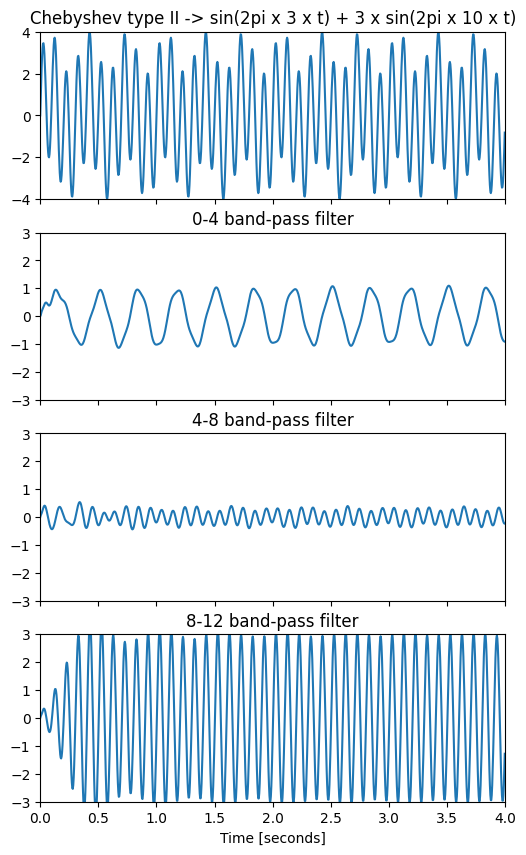

In [85]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig)
ax1.set_title('Chebyshev type II -> sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t)')
ax1.axis([0, 1, -4, 4])

sos1 = signal.cheby2(15, 20, [0.1, 4], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos1, sig)
ax2.plot(t, filtered)
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

sos2 = signal.cheby2(10, 20, [4, 8], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos2, sig)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

sos3 = signal.cheby2(10, 20, [8, 12], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos3, sig)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
--------------

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


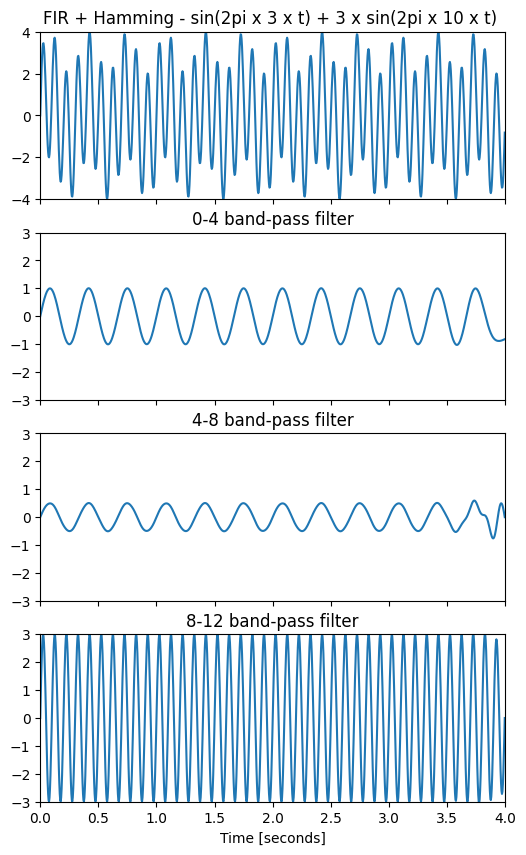

In [86]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig)
ax1.set_title('FIR + Hamming - sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t) ')
ax1.axis([0, 1, -4, 4])


filtered = mne.filter.filter_data(sig, 250, 0, 4)
ax2.plot(t, filtered)
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

filtered = mne.filter.filter_data(sig, 250, 4, 8)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

filtered = mne.filter.filter_data(sig, 250, 8, 12)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (3, 1000)

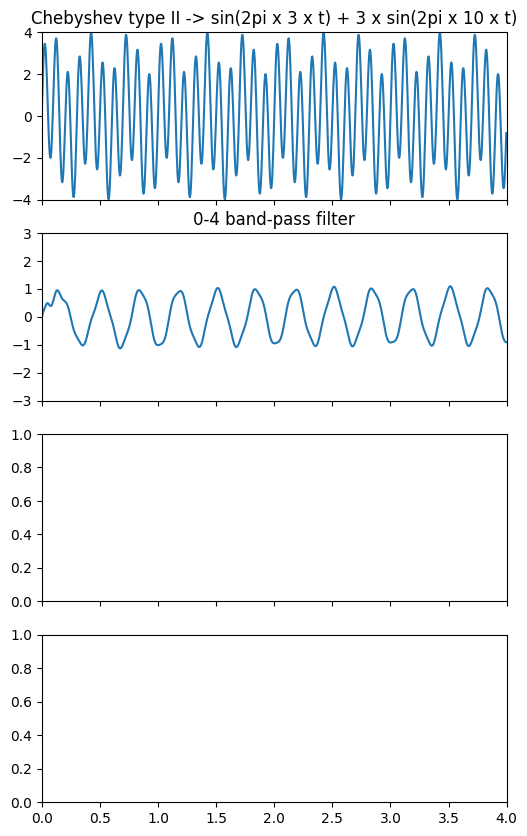

In [29]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)

sig = np.tile(sig, (3, 1))

print(sig.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig[0])
ax1.set_title('Chebyshev type II -> sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t)')
ax1.axis([0, 1, -4, 4])

sos1 = signal.cheby2(15, 20, [0.1, 4], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos1, sig)
ax2.plot(t, filtered[0])
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

sos2 = signal.cheby2(10, 20, [4, 8], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos2, sig)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

sos3 = signal.cheby2(10, 20, [8, 12], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos3, sig)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

# CSP Validation:

In [199]:
t = np.linspace(0, 5, 1250, False)  # 4 second
sig1 = np.sin(2*np.pi*35*t) + 3 * np.sin(2*np.pi*10*t)
sig2 = np.sin(2*np.pi*100*t) + 3 * np.sin(2*np.pi*50*t)

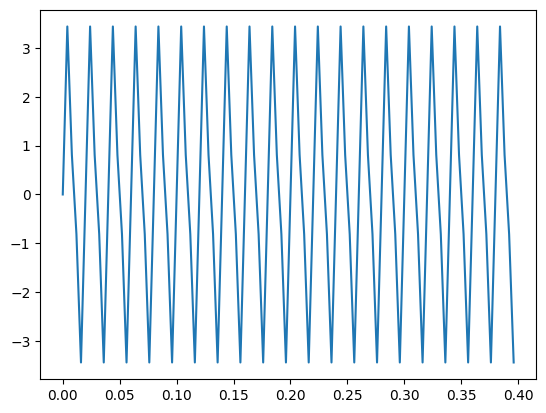

In [200]:
plt.plot(t[:100], sig2[:100])

In [201]:
np.expand_dims(sig1, axis=1)

array([[ 0.        ],
       [ 1.5165829 ],
       [ 2.42754827],
       ...,
       [-2.53539499],
       [-2.42754827],
       [-1.5165829 ]])

In [202]:
sig1 = np.expand_dims(sig1, axis=0)
sig2 = np.expand_dims(sig2, axis=0)
sig1.shape, sig2.shape

((1, 1250), (1, 1250))

In [203]:
sig = np.concatenate((sig1, sig2), axis=0)

In [204]:
sig = np.expand_dims(sig, axis=0)
sig.shape

(1, 2, 1250)

In [205]:
s_epoch = np.tile(sig, (50, 1, 1))
s_epoch.shape, (s_epoch[0, :, :] == s_epoch[10, :, :]).all()

((50, 2, 1250), True)

In [206]:
s_train_epochs = slicer(s_epoch, num_splits=2)

In [207]:
s_train_epochs.shape

(50, 2, 2, 625)

In [208]:
s_no_encoded_train_labels = np.random.randint(0, 3, (50, 1))

In [209]:
mne.set_log_level('warning')
train_feats, test_feats, filtered_data = Preprocess_validator(s_train_epochs, s_no_encoded_train_labels, s_train_epochs, sampling_freq = 250, n_components=2)

The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011005878448486328
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011038541793823242
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.010999679565429688
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011005163192749023
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012004613876342773
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.010001897811889648
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012001514434814453
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012008190155029297
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.009999990463256836
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012001514434814453
The filtered data shape: (100, 2, 625)
Time taken for csp ca

In [210]:
train_feats.shape

(50, 2, 16, 2)

In [211]:
filtered_data.shape

(50, 2, 2, 625)

In [212]:
(filtered_data[0, :, :, :] == filtered_data[10, :, :, :]).all()

True

In [213]:
(filtered_data[:, :, 0, :] == filtered_data[:, :, 0, :]).all()

True

In [214]:
(filtered_data[:, 0, :, :] == filtered_data[:, 1, :, :]).any()

True

In [215]:
(s_train_epochs[:, 0, :, :] == s_train_epochs[:, 1, :, :]).any()

False

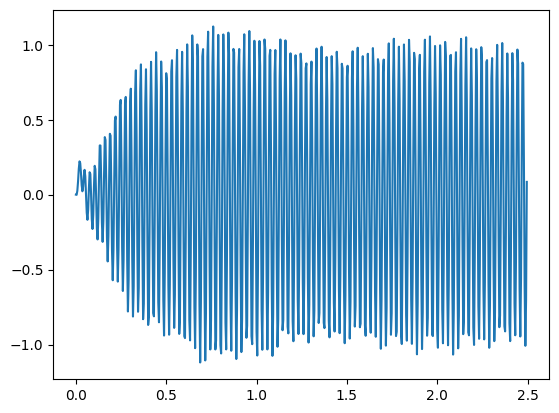

In [216]:
y = filtered_data[0, 1, 0, :]
plt.plot(t[:625], y)

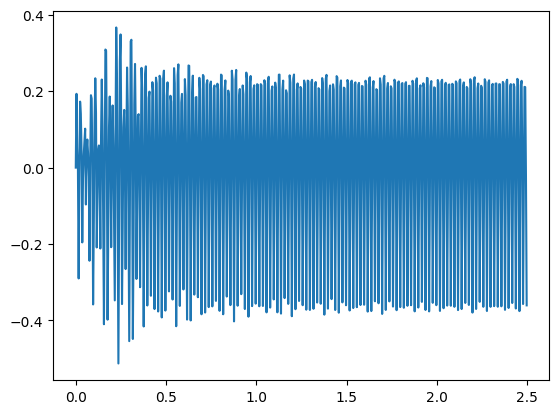

In [217]:
y = filtered_data[0, 0, 1, :]
plt.plot(t[:625], y)

# Heatmap on FBCSP:

In [218]:
with open("train_features_fortestID_[0].pickle", "rb") as f:
    train_features = pickle.load(f)
    f.close()

In [219]:
train_features.shape

(2160, 5, 16, 16)

In [221]:
new_array = np.zeros((2160, 16, 80))

In [222]:
for i in range(5):
    new_array[:, :, 16*i:16*i+16] = train_features[:, i, :, :]
    print((new_array[:, :, 16*i:16*i+16]).shape)

(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)


In [223]:
new_array.shape

(2160, 16, 80)

In [225]:
heat_value = new_array.mean(axis=0)

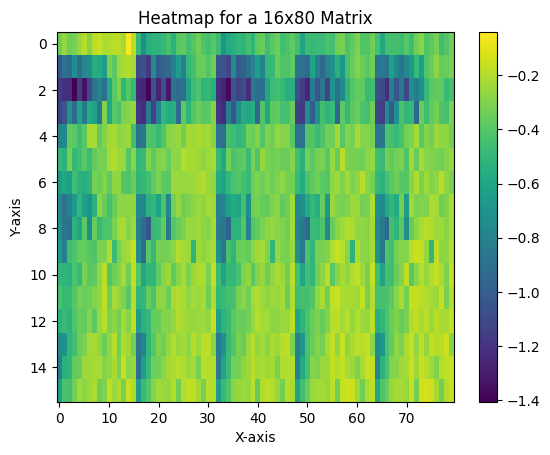

In [226]:
plt.imshow(heat_value, cmap='viridis', aspect='auto')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Heatmap for a 16x80 Matrix')

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()

In [29]:
all_epochs = np.concatenate(all_data_epochs)
all_labels = np.concatenate(no_encode)


mne.set_log_level('warning')
all_features, _ = feature_extraction_cheby2(all_epochs, all_labels, all_epochs, sampling_freq = 250, n_components=16)
#sys.stdout.close()
#sys.stdout = original_stdout


print("All epochs features shape:", all_features.shape)


with open("All_data_features.pickle", "wb") as f:
    pickle.dump(all_features, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()


The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.928704977035522
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.971172571182251
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  11.614934921264648
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.451647520065308
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.614197254180908
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  11.34934687614441
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.473000526428223
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.482449293136597
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.383591890335083
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.589037895202637
The filtered data shape: (12240, 22, 200)
Time take

NameError: name 'train_features' is not defined

In [47]:
new_array = np.zeros((2448, 16, 80))
for i in range(5):
    new_array[:, :, 16*i:16*i+16] = all_features[:, i, :, :]
    print((new_array[:, :, 16*i:16*i+16]).shape)
print("\n\n")
print("new array shape:", new_array.shape)

(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)



new array shape: (2448, 16, 80)


In [30]:
print("All epochs features shape:", all_features.shape)

All epochs features shape: (2448, 5, 16, 16)


In [48]:
epochs_1 = new_array[(all_labels == 0).squeeze(), :, :]
epochs_2 = new_array[(all_labels == 1).squeeze(), :, :]
epochs_3 = new_array[(all_labels == 2).squeeze(), :, :]
epochs_4 = new_array[(all_labels == 3).squeeze(), :, :]


In [49]:
print("Left epochs shape:  ", epochs_1.shape)
print("Right epochs shape: ", epochs_2.shape)
print("Feet epochs shape:  ", epochs_3.shape)
print("Tongue epochs shape:", epochs_4.shape)

Left epochs shape:   (648, 16, 80)
Right epochs shape:  (648, 16, 80)
Feet epochs shape:   (576, 16, 80)
Tongue epochs shape: (576, 16, 80)


In [50]:
epochs_1 = epochs_1.mean(axis=0)
epochs_2 = epochs_2.mean(axis=0)
epochs_3 = epochs_3.mean(axis=0)
epochs_4 = epochs_4.mean(axis=0)

In [62]:
epochs_1

(16, 80)

In [34]:
(all_labels == 0).sum()

648

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 800x1000 with 0 Axes>

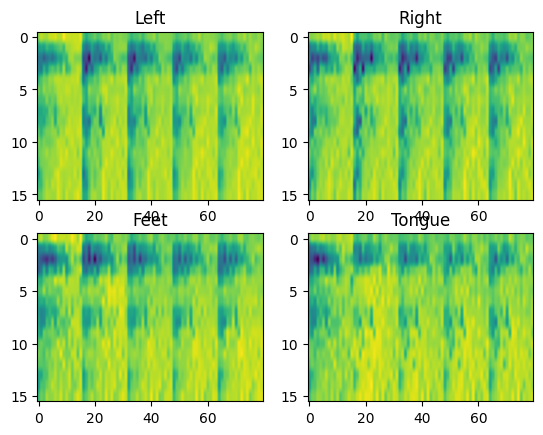

In [59]:
plt.figure(1, (8, 10))
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(epochs_1, cmap='viridis', aspect='auto')
axs[0, 0].set_title("Left")

axs[0, 1].imshow(epochs_2, cmap='viridis', aspect='auto')
axs[0, 1].set_title("Right")

axs[1, 0].imshow(epochs_3, cmap='viridis', aspect='auto')
axs[1, 0].set_title("Feet")

axs[1, 1].imshow(epochs_4, cmap='viridis', aspect='auto')
axs[1, 1].set_title("Tongue")

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()